In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.__version__

'0.12.0'

In [3]:
pd.__version__

'1.3.4'

In [4]:
# perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniref90/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240612/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_fnn_2l_lr1e-4/aligned_msl2048/processed")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [31]:
def get_perturbation_output(perturbation_processed_output_dir):
    perturbation_output_files = os.listdir(perturbation_processed_output_dir)
    print(f"Number of perturbation output files = {len(perturbation_output_files)}")

    perturbed_output_dfs = []
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
        # TODO: HACK REMOVE THIS COLUMN RENAME
        df.rename(columns={"Human": "0", "6": "Human"}, inplace=True)
        
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        # orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]
        
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        # df["orig_y_pred"] = orig_pred_class
        # df["new_y_pred"] = df[classes].idxmax(axis=1)
    
        perturbed_output_dfs.append(df)
    return pd.concat(perturbed_output_dfs)

In [32]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [33]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [34]:
perturbed_output_df = get_perturbation_output(perturbation_processed_output_dir)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

Number of perturbation output files = 94
perturbed_output_df shape = (2978369, 15)



#### WIV04 reference sequence

In [35]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

uniref90_id                                        aligned_seq  \
0       WIV04  --------------MFVFLVLLPLVSS--------Q----------...   

                                                 seq  \
0  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                    virus_name virus_host_name  \
0  WIV04(MN996528.1) Wuhan variant index virus    homo sapiens   

  human_binary_label  
0       homo sapiens

In [36]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2418


'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [37]:
wiv04_aligned_seq[:2049]

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [38]:
wiv04_aligned_seq[2049:]

'KVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFC-GKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC---------HDGKAHFPRE---GVFVS-----NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPEL----DSFKEELDKYFKNHTSPDVDLGDIS-GINASV--VNIQKEID--------------RLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIML-CCMTS-----CCS-----------CLKG------------CCSCGSCCKFD-----------EDDSEPVLKGVKLHYT--'

In [39]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [40]:
perturbed_output_df

0         1         2         3         4         5     Human  \
0      0.000021  0.000408  0.023282  0.000002  0.000056  0.000034  0.944711   
1      0.000022  0.000409  0.023270  0.000002  0.000059  0.000036  0.943135   
2      0.000018  0.000325  0.020857  0.000002  0.000056  0.000038  0.939987   
3      0.000021  0.000408  0.023282  0.000002  0.000056  0.000034  0.944711   
4      0.000022  0.000482  0.022938  0.000002  0.000068  0.000038  0.939452   
...         ...       ...       ...       ...       ...       ...       ...   
31821  0.000017  0.000387  0.019109  0.000002  0.000047  0.000023  0.953406   
31822  0.000017  0.000386  0.019068  0.000002  0.000047  0.000023  0.953450   
31823  0.000017  0.000387  0.019109  0.000002  0.000047  0.000023  0.953406   
31824  0.000017  0.000378  0.019072  0.000002  0.000047  0.000023  0.953501   
31825  0.000017  0.000389  0.019069  0.000002  0.000047  0.000023  0.953443   

              7          uniref90_id y_true orig_token  perturb_pos new_token  \
0      0.031486  UniRef90_A0A7T6Y5W2  Human          T         2140         D   
1      0.033067  UniRef90_A0A7T6Y5W2  Human          N         2021         W   
2      0.038716  UniRef90_A0A7T6Y5W2  Human          P          790         W   
3      0.031486  UniRef90_A0A7T6Y5W2  Human          L         2222         Z   
4      0.036998  UniRef90_A0A7T6Y5W2  Human          Y          431         B   
...         ...                  ...    ...        ...          ...       ...   
31821  0.027009  UniRef90_A0A8B1K2U2  Human          Y         2317         V   
31822  0.027007  UniRef90_A0A8B1K2U2  Human          V         1735         B   
31823  0.027009  UniRef90_A0A8B1K2U2  Human          K         2364         B   
31824  0.026959  UniRef90_A0A8B1K2U2  Human          X          128         I   
31825  0.027010  UniRef90_A0A8B1K2U2  Human          P         1619         S   

       Human_pred_diff  abs_Human_pred_diff  perturb_seq_pos  
0             0.000000             0.000000             1076  
1            -0.001576             0.001576              960  
2            -0.004723             0.004723              322  
3             0.000000             0.000000             1141  
4            -0.005258             0.005258              170  
...                ...                  ...              ...  
31821         0.000000             0.000000             1215  
31822         0.000044             0.000044              729  
31823         0.000000             0.000000             1245  
31824         0.000095             0.000095               63  
31825         0.000037             0.000037              631  

[2978369 rows x 16 columns]

In [41]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [42]:
perturbed_output_df

0         1         2         3         4         5     Human  \
0      0.000021  0.000408  0.023282  0.000002  0.000056  0.000034  0.944711   
1      0.000022  0.000409  0.023270  0.000002  0.000059  0.000036  0.943135   
2      0.000018  0.000325  0.020857  0.000002  0.000056  0.000038  0.939987   
3      0.000021  0.000408  0.023282  0.000002  0.000056  0.000034  0.944711   
4      0.000022  0.000482  0.022938  0.000002  0.000068  0.000038  0.939452   
...         ...       ...       ...       ...       ...       ...       ...   
31821  0.000017  0.000387  0.019109  0.000002  0.000047  0.000023  0.953406   
31822  0.000017  0.000386  0.019068  0.000002  0.000047  0.000023  0.953450   
31823  0.000017  0.000387  0.019109  0.000002  0.000047  0.000023  0.953406   
31824  0.000017  0.000378  0.019072  0.000002  0.000047  0.000023  0.953501   
31825  0.000017  0.000389  0.019069  0.000002  0.000047  0.000023  0.953443   

              7          uniref90_id y_true orig_token  perturb_pos new_token  \
0      0.031486  UniRef90_A0A7T6Y5W2  Human          T         2140         D   
1      0.033067  UniRef90_A0A7T6Y5W2  Human          N         2021         W   
2      0.038716  UniRef90_A0A7T6Y5W2  Human          P          790         W   
3      0.031486  UniRef90_A0A7T6Y5W2  Human          L         2222         Z   
4      0.036998  UniRef90_A0A7T6Y5W2  Human          Y          431         B   
...         ...                  ...    ...        ...          ...       ...   
31821  0.027009  UniRef90_A0A8B1K2U2  Human          Y         2317         V   
31822  0.027007  UniRef90_A0A8B1K2U2  Human          V         1735         B   
31823  0.027009  UniRef90_A0A8B1K2U2  Human          K         2364         B   
31824  0.026959  UniRef90_A0A8B1K2U2  Human          X          128         I   
31825  0.027010  UniRef90_A0A8B1K2U2  Human          P         1619         S   

       Human_pred_diff  abs_Human_pred_diff  perturb_seq_pos  
0             0.000000             0.000000             1076  
1            -0.001576             0.001576              960  
2            -0.004723             0.004723              322  
3             0.000000             0.000000             1141  
4            -0.005258             0.005258              170  
...                ...                  ...              ...  
31821         0.000000             0.000000             1215  
31822         0.000044             0.000044              729  
31823         0.000000             0.000000             1245  
31824         0.000095             0.000095               63  
31825         0.000037             0.000037              631  

[2952919 rows x 16 columns]

# Overview

### Distribution of Human class difference

In [43]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [45]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 674 (0.02282487260910306)
Distribution of full perturbation output
n=2952919
       start       end    count  percentage
0  -0.221307 -0.183833       33    0.001118
1  -0.183833 -0.146359       93    0.003149
2  -0.146359 -0.108885       92    0.003116
3  -0.108885 -0.071411      329    0.011142
4  -0.071411 -0.033937      943    0.031935
5  -0.033937  0.003537  2936050   99.428735
6   0.003537  0.041011    14607    0.494663
7   0.041011  0.078485      303    0.010261
8   0.078485  0.115959      105    0.003556
9   0.115959  0.153433       89    0.003014
10  0.153433  0.190908       61    0.002066
11  0.190908  0.228382       37    0.001253
12  0.228382  0.265856       35    0.001185
13  0.265856  0.303330       20    0.000677
14  0.303330  0.340804       69    0.002337
15  0.340804  0.378278       23    0.000779
16  0.378278  0.415752       18    0.000610
17  0.415752  0.453226        3    0.000102
18  0.453226  0.490700        6   

<Figure size 432x288 with 0 Axes>

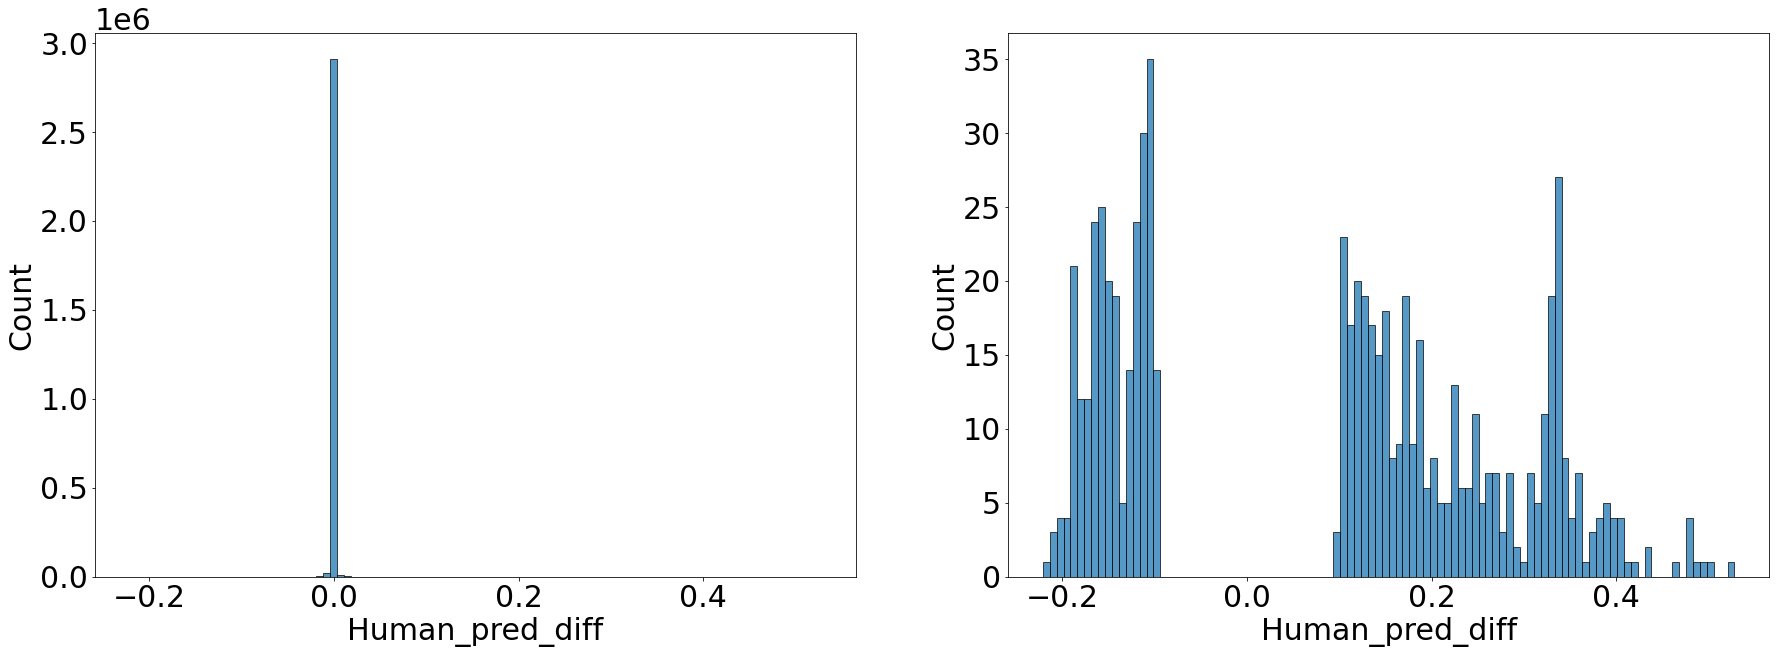

In [46]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

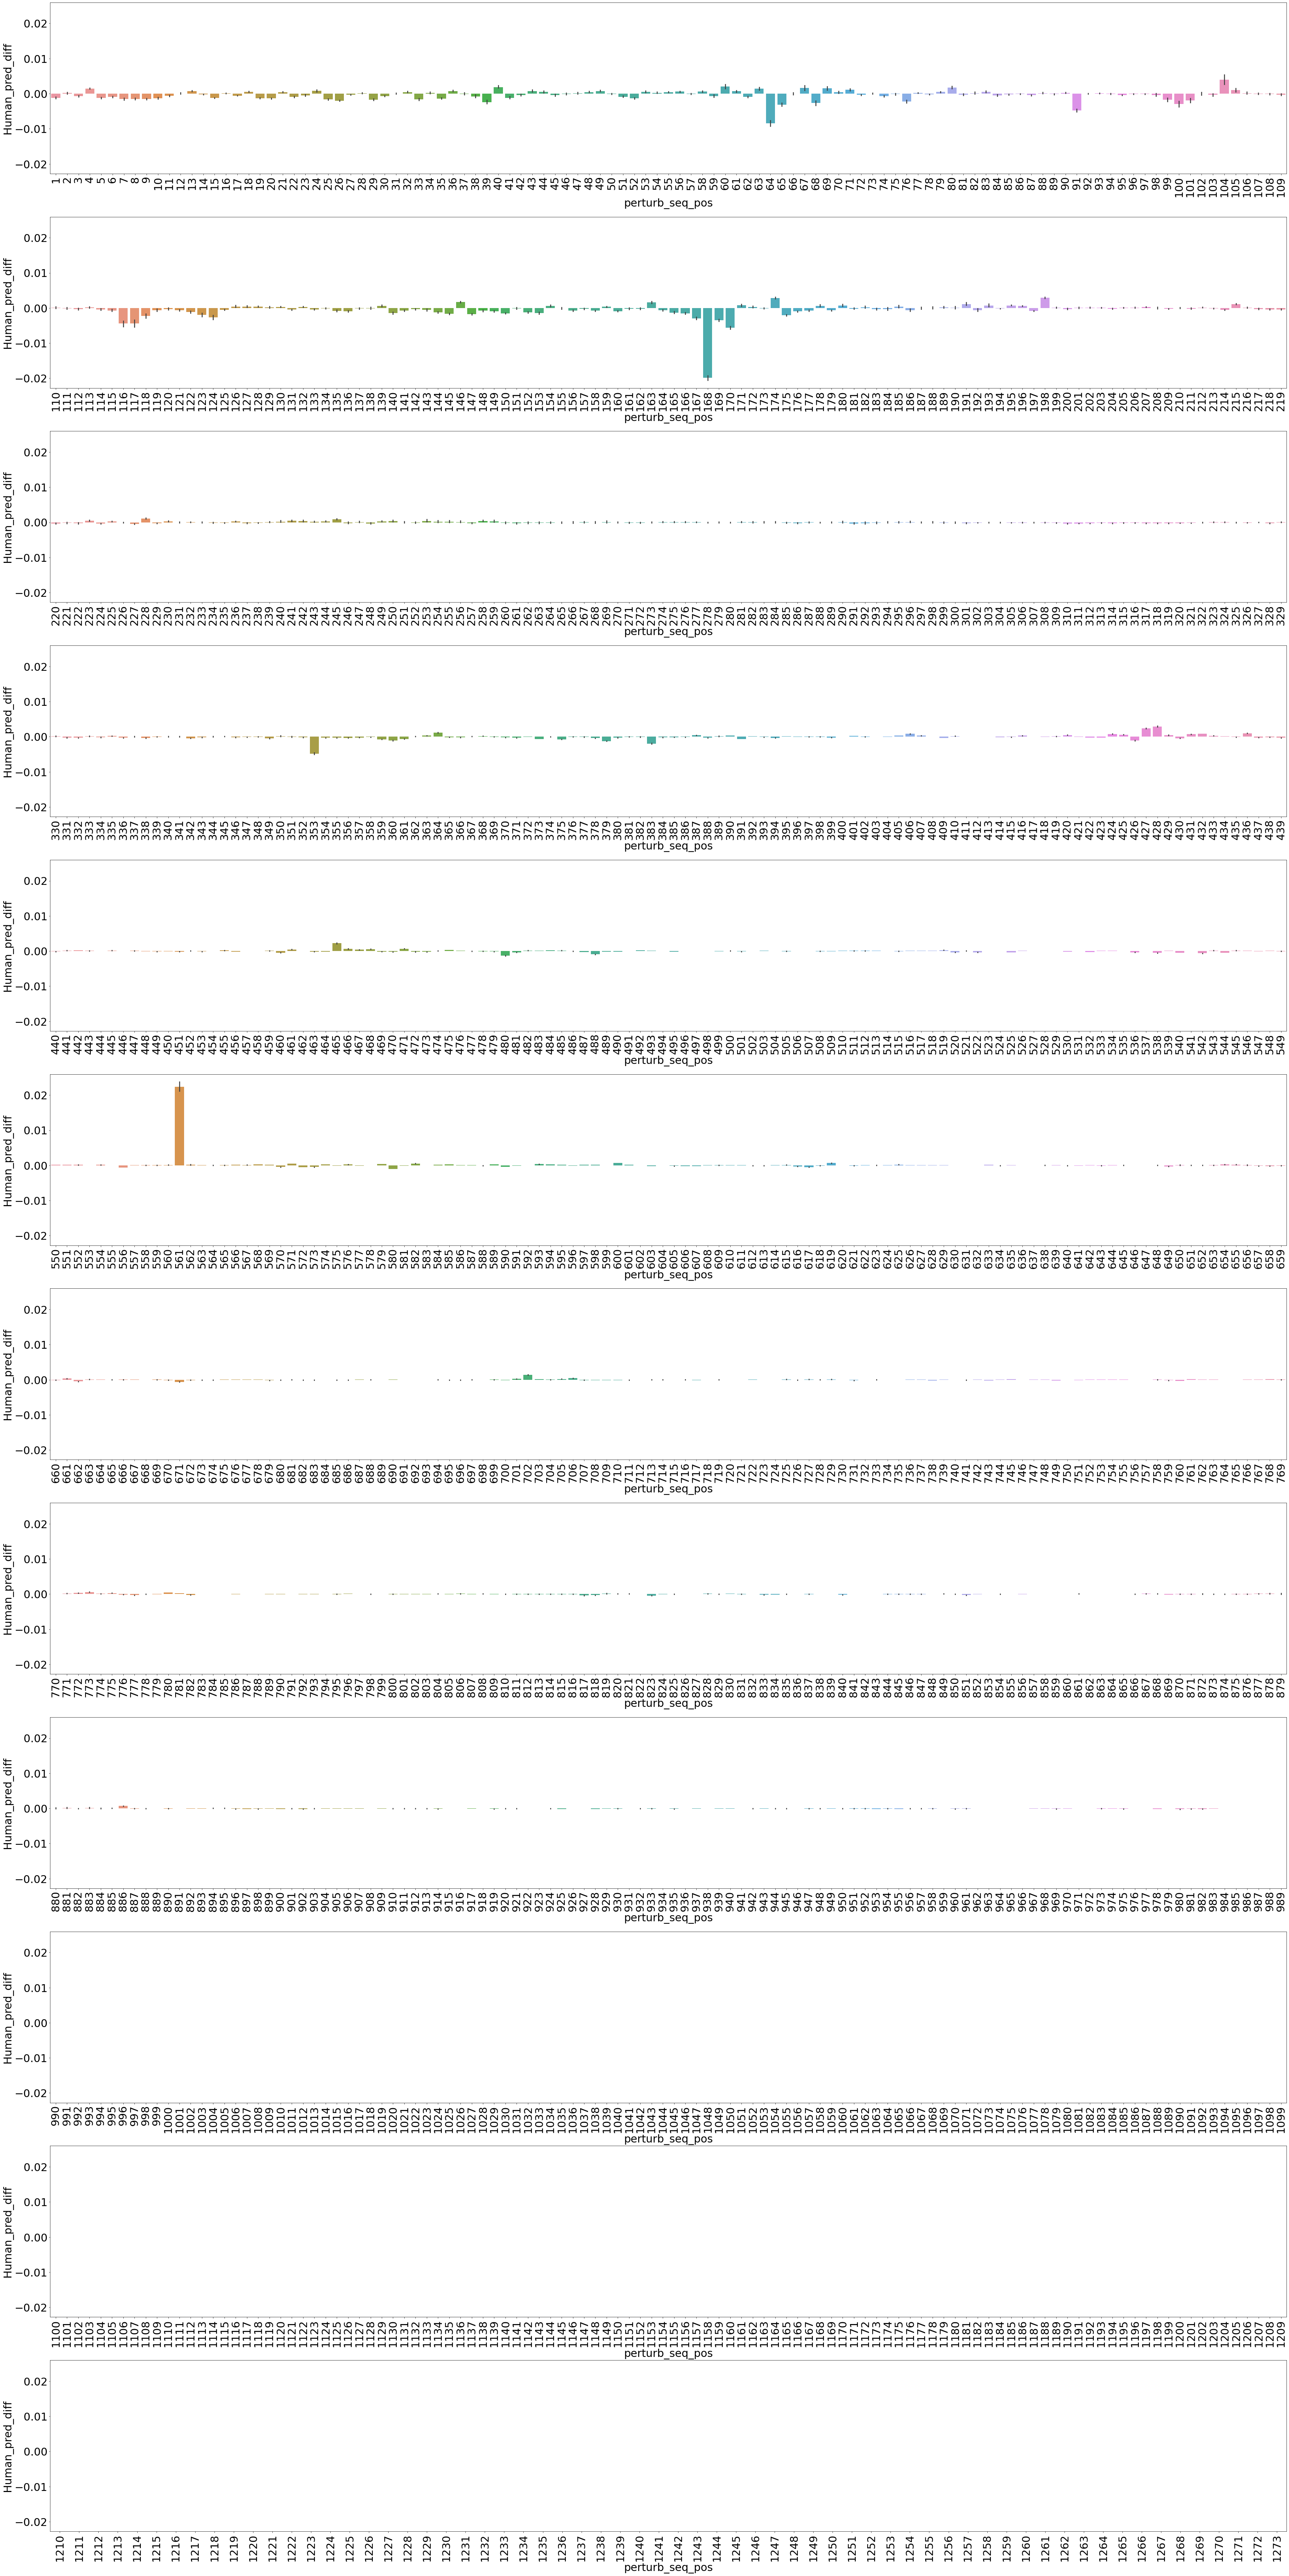

In [47]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(50, 100), sharex=False, sharey=True)

j = 0
for i in range(0, 1274, 110):
    plot_df = perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] >= i) & (perturbed_output_df["perturb_seq_pos"] < i+110)]
    sns.barplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

# plt.clf()
# plt.figure(figsize=(70, 20))
# plt.rcParams["xtick.labelsize"] = 10
# plt.rcParams["ytick.labelsize"] = 10
# plt.rcParams.update({'font.size': 10})
# sns.barplot(perturbed_output_df, x="perturb_seq_pos", y=pred_diff_col)
# plt.xticks(rotation=90)
# plt.show()

In [48]:
perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] > 500) & (perturbed_output_df["abs_Human_pred_diff"] > 0)]

0         1         2         3         4         5     Human  \
1      0.000022  0.000409  0.023270  0.000002  0.000059  0.000036  0.943135   
7      0.000021  0.000410  0.023238  0.000002  0.000056  0.000034  0.944576   
15     0.000021  0.000408  0.023356  0.000002  0.000056  0.000034  0.944678   
19     0.000021  0.000411  0.023282  0.000002  0.000056  0.000034  0.944669   
22     0.000021  0.000416  0.023093  0.000002  0.000056  0.000034  0.944461   
...         ...       ...       ...       ...       ...       ...       ...   
31808  0.000017  0.000386  0.019345  0.000002  0.000048  0.000024  0.952611   
31815  0.000017  0.000384  0.019069  0.000002  0.000047  0.000023  0.953512   
31818  0.000017  0.000390  0.019034  0.000002  0.000046  0.000023  0.953489   
31822  0.000017  0.000386  0.019068  0.000002  0.000047  0.000023  0.953450   
31825  0.000017  0.000389  0.019069  0.000002  0.000047  0.000023  0.953443   

              7          uniref90_id y_true orig_token  perturb_pos new_token  \
1      0.033067  UniRef90_A0A7T6Y5W2  Human          N         2021         W   
7      0.031663  UniRef90_A0A7T6Y5W2  Human          T         1618         G   
15     0.031444  UniRef90_A0A7T6Y5W2  Human          Y         1917         D   
19     0.031525  UniRef90_A0A7T6Y5W2  Human          I         1838         J   
22     0.031917  UniRef90_A0A7T6Y5W2  Human          R         1553         F   
...         ...                  ...    ...        ...          ...       ...   
31808  0.027566  UniRef90_A0A8B1K2U2  Human          C         1495         Q   
31815  0.026946  UniRef90_A0A8B1K2U2  Human          V         1684         I   
31818  0.026999  UniRef90_A0A8B1K2U2  Human          I         1605         O   
31822  0.027007  UniRef90_A0A8B1K2U2  Human          V         1735         B   
31825  0.027010  UniRef90_A0A8B1K2U2  Human          P         1619         S   

       Human_pred_diff  abs_Human_pred_diff  perturb_seq_pos  
1            -0.001576             0.001576              960  
7            -0.000134             0.000134              630  
15           -0.000032             0.000032              873  
19           -0.000042             0.000042              805  
22           -0.000250             0.000250              577  
...                ...                  ...              ...  
31808        -0.000795             0.000795              538  
31815         0.000106             0.000106              687  
31818         0.000083             0.000083              624  
31822         0.000044             0.000044              729  
31825         0.000037             0.000037              631  

[1136983 rows x 16 columns]

### Cut-off: mean=0 and variance=0

In [49]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_df_1["perturb_seq_pos"].nunique()

1007

<Figure size 432x288 with 0 Axes>

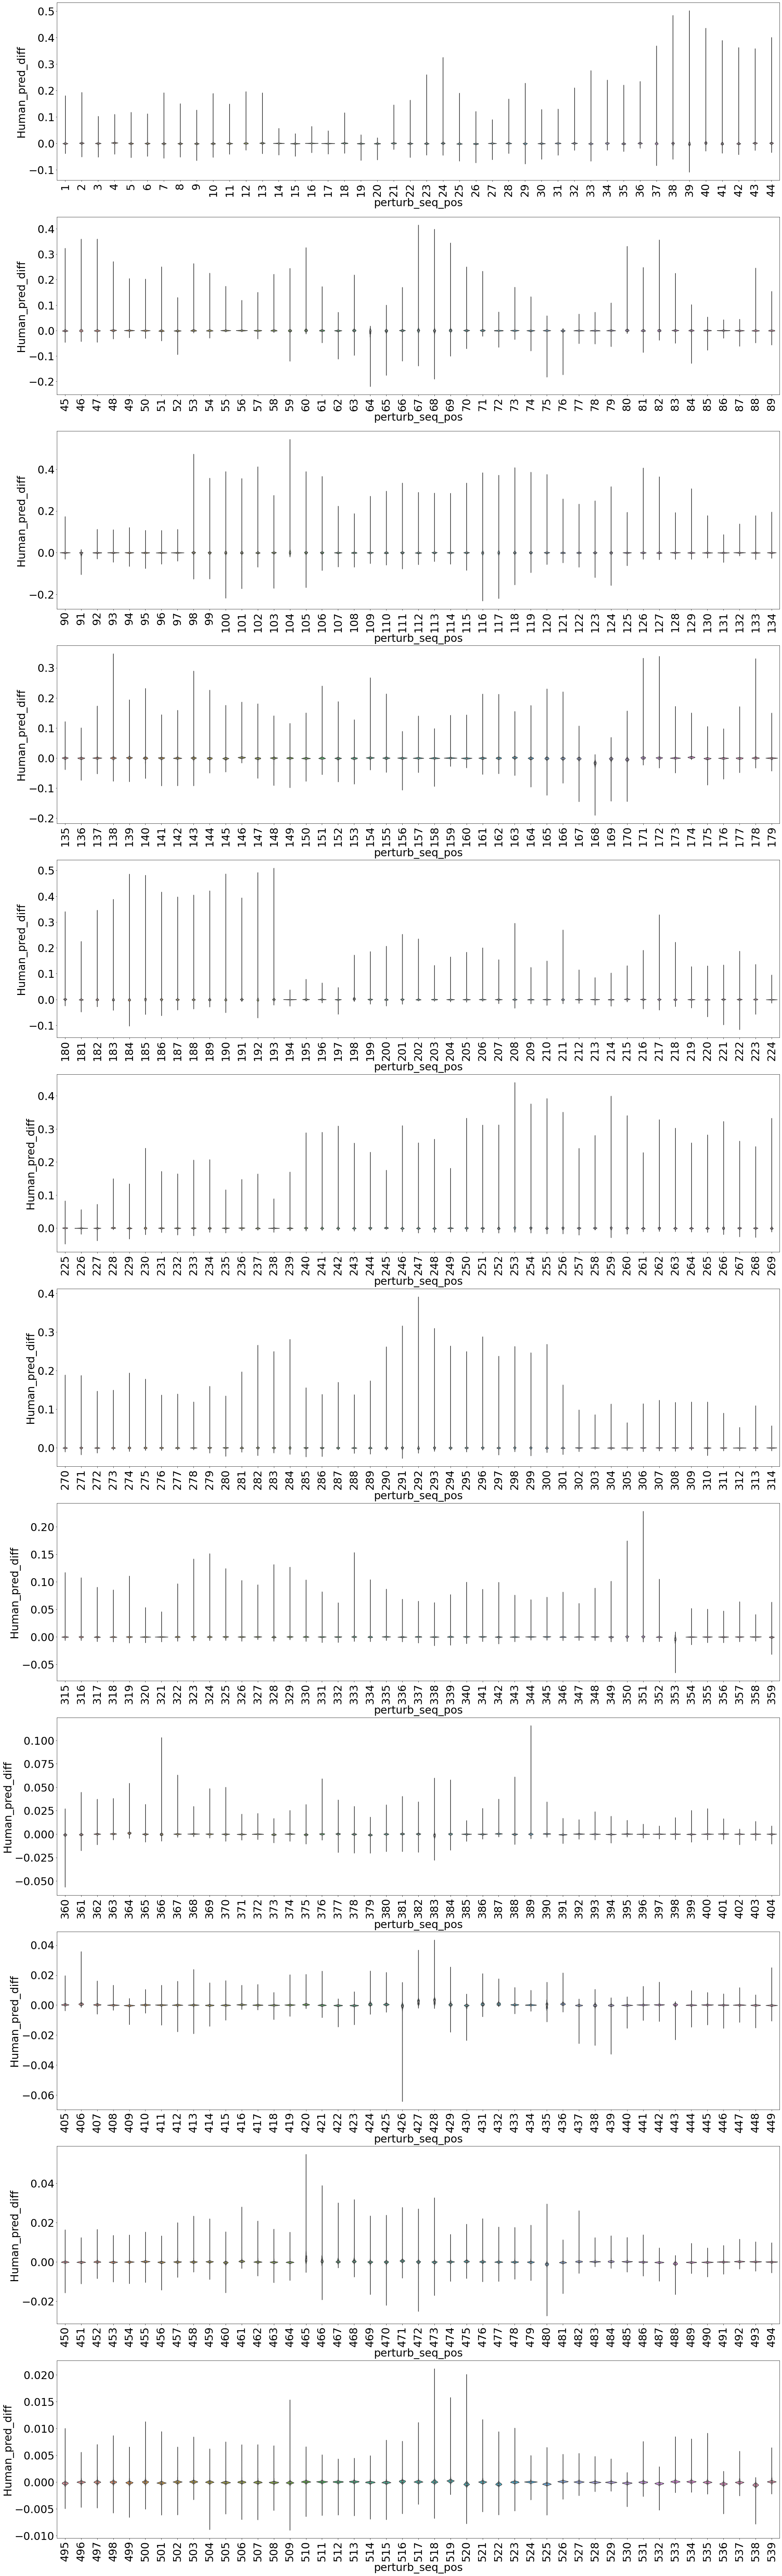

In [50]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(30, 100), sharex=False, sharey=False)

j = 0
for i in range(0, 501, 45):
    plot_df = cut_off_df_1[(cut_off_df_1["perturb_seq_pos"] >= i) & (cut_off_df_1["perturb_seq_pos"] < i+45)]
    sns.violinplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [22]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 579
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 134
1 intersection 2: 134
1 minus 2: 445
2 minus 1: 0
is 2 subset of 1: True


<Figure size 640x480 with 0 Axes>

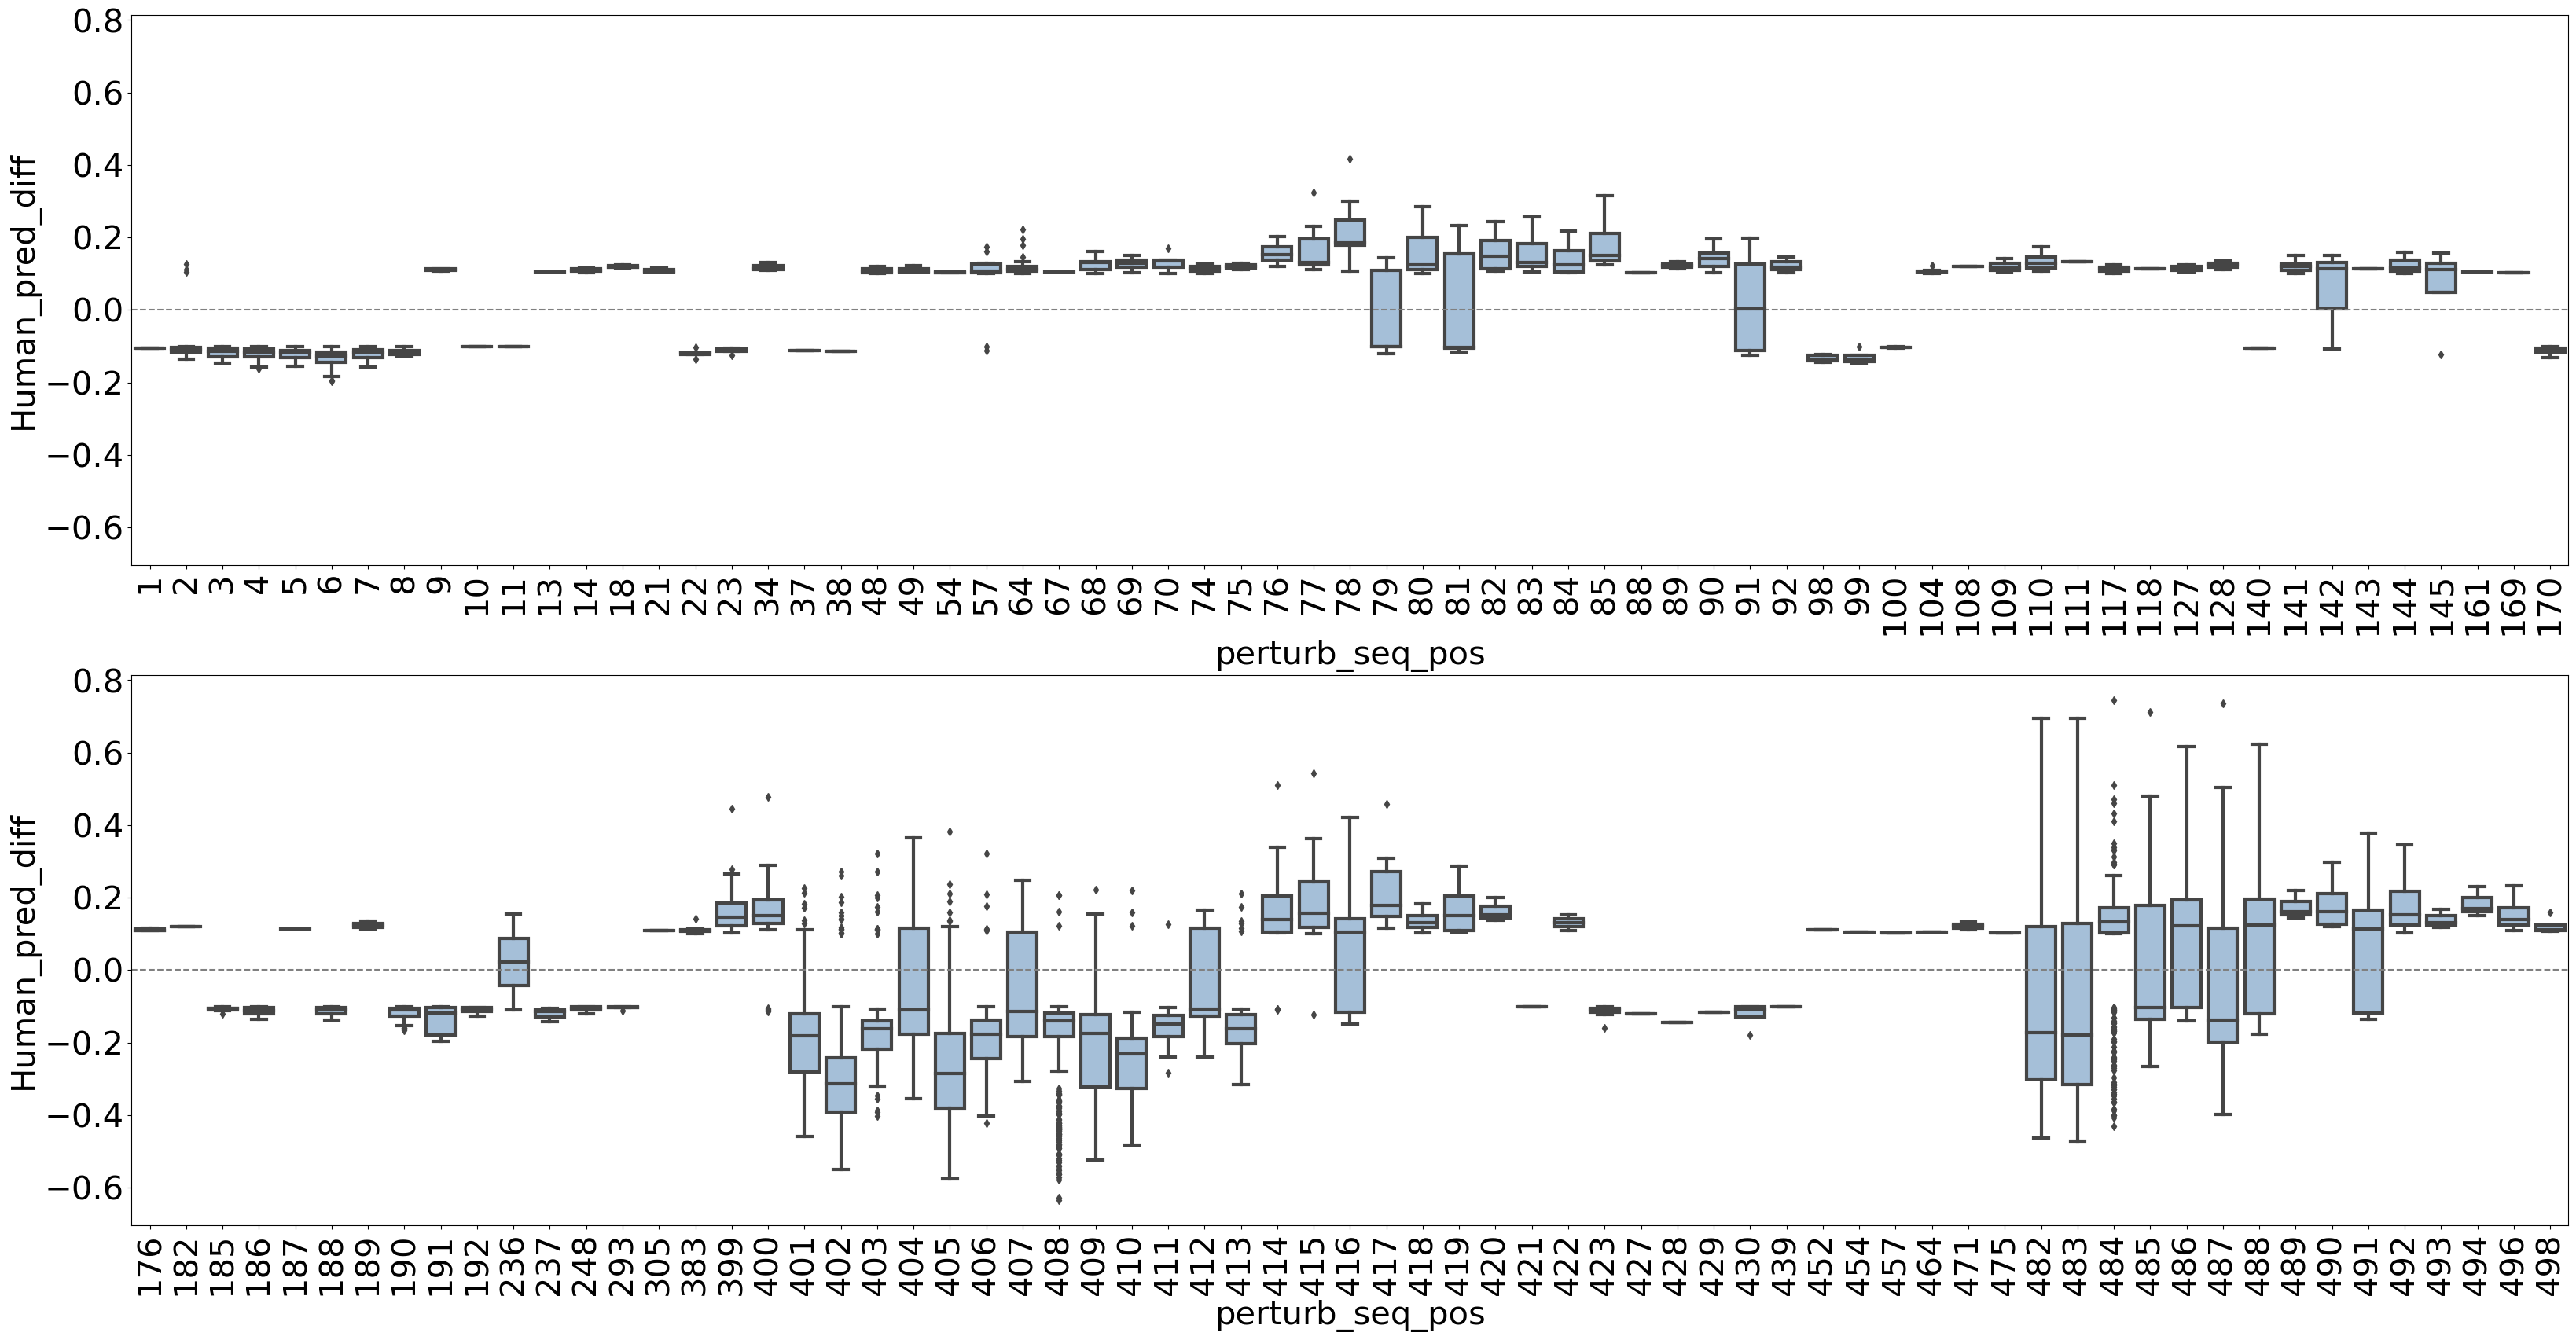

In [58]:
plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 20), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"] <= 170],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[0], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[0].tick_params(axis='x', rotation=90)
axs[0].axhline(0.0, color="gray", linestyle="--")
sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"] > 170],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[1], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[1].tick_params(axis='x', rotation=90)
axs[1].axhline(0.0, color="gray", linestyle="--")
#sns.stripplot(data=cut_off_df_2, x="Human_pred_diff", y="perturb_seq_pos", hue="new_token", orient="h", s=10, ax=axs[1], linewidth=1)

plt.show()


### Important positions causing class change from Human

3634
3.907539900935608


<Figure size 640x480 with 0 Axes>

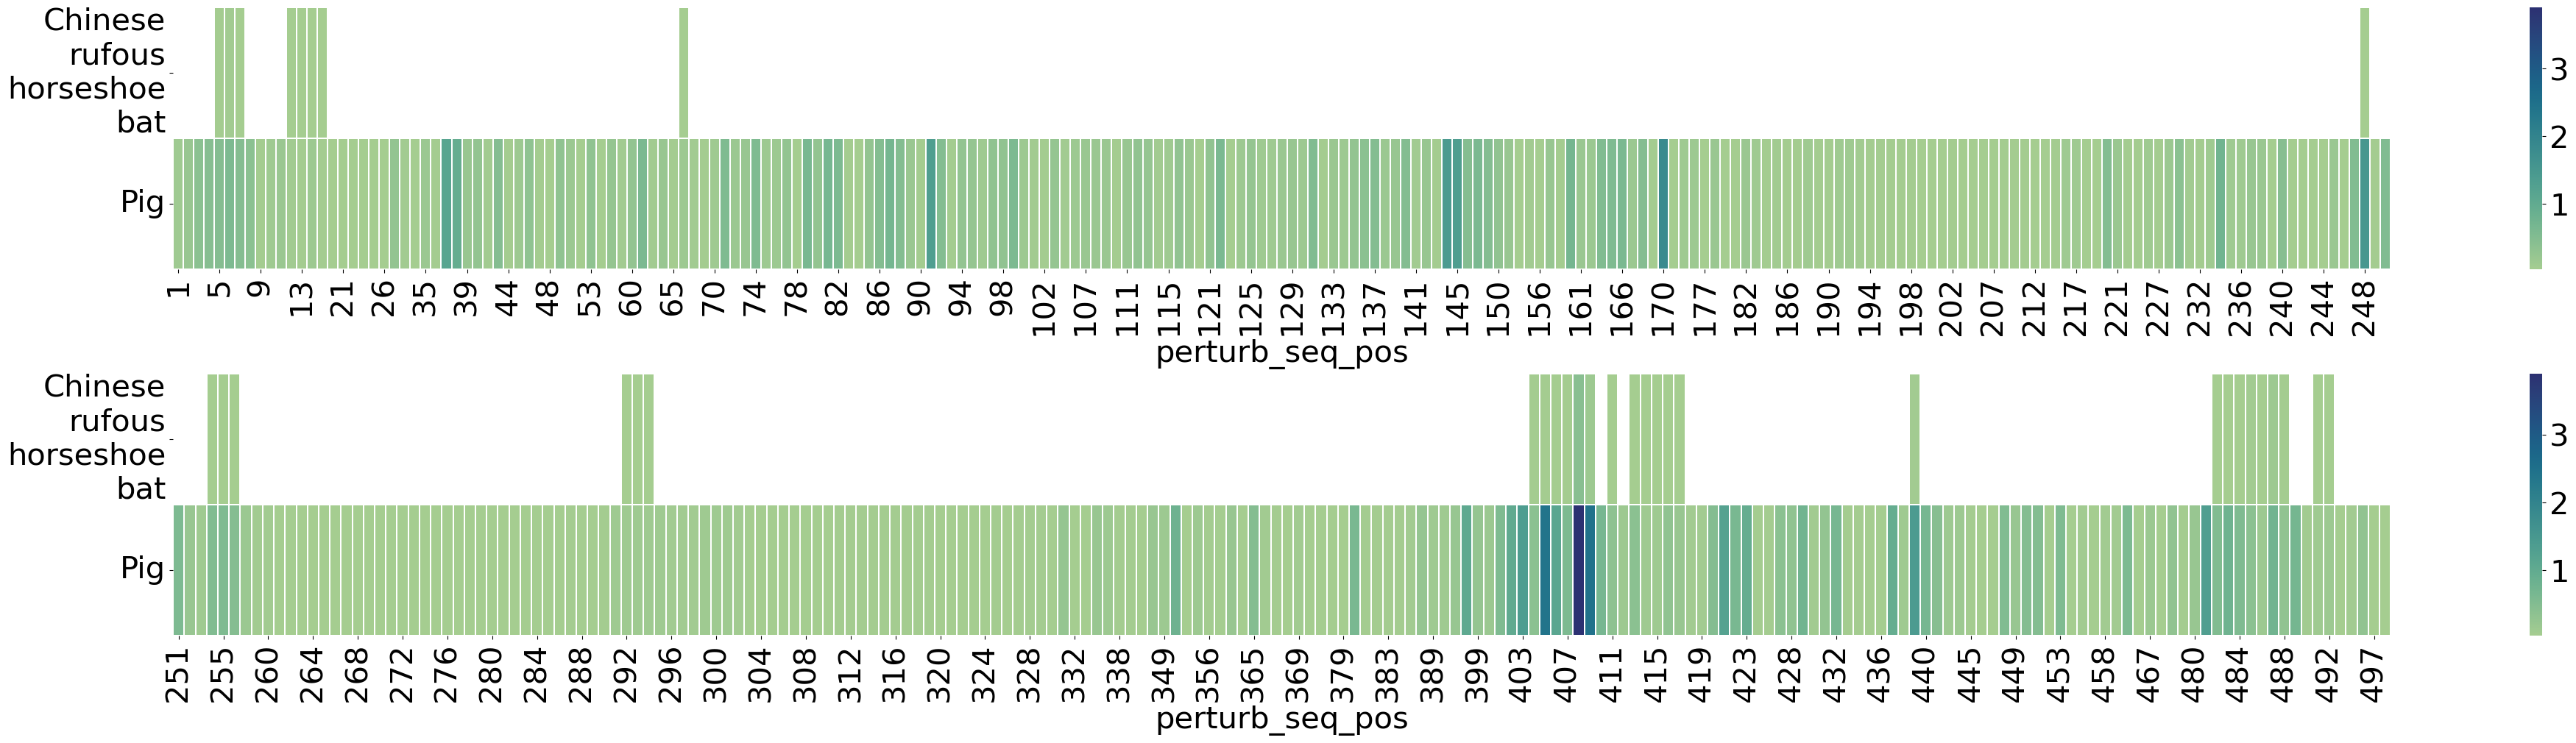

In [24]:
class_change_df = perturbed_output_df[(perturbed_output_df["orig_y_pred"] == "Human") & (perturbed_output_df["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
max_val = df["%"].max()
print(max_val)
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
df = df.reset_index()
# df.drop(["new_y_pred"], axis=1, inplace=True)

plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 10), sharey=True)
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

sns.heatmap(data=df[df["perturb_seq_pos"] <=250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[0], vmax=max_val)
wrap_yticklabels(axs[0], label_width=10, break_long_words=True)
axs[0].tick_params(axis='x', rotation=90)


sns.heatmap(data=df[df["perturb_seq_pos"] > 250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[1], vmax=max_val)
wrap_yticklabels(axs[1], label_width=10, break_long_words=True)
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout(pad=.1)
plt.show()


### Important positions causing class change from Human due to difference >= 0.1

489


<Figure size 640x480 with 0 Axes>

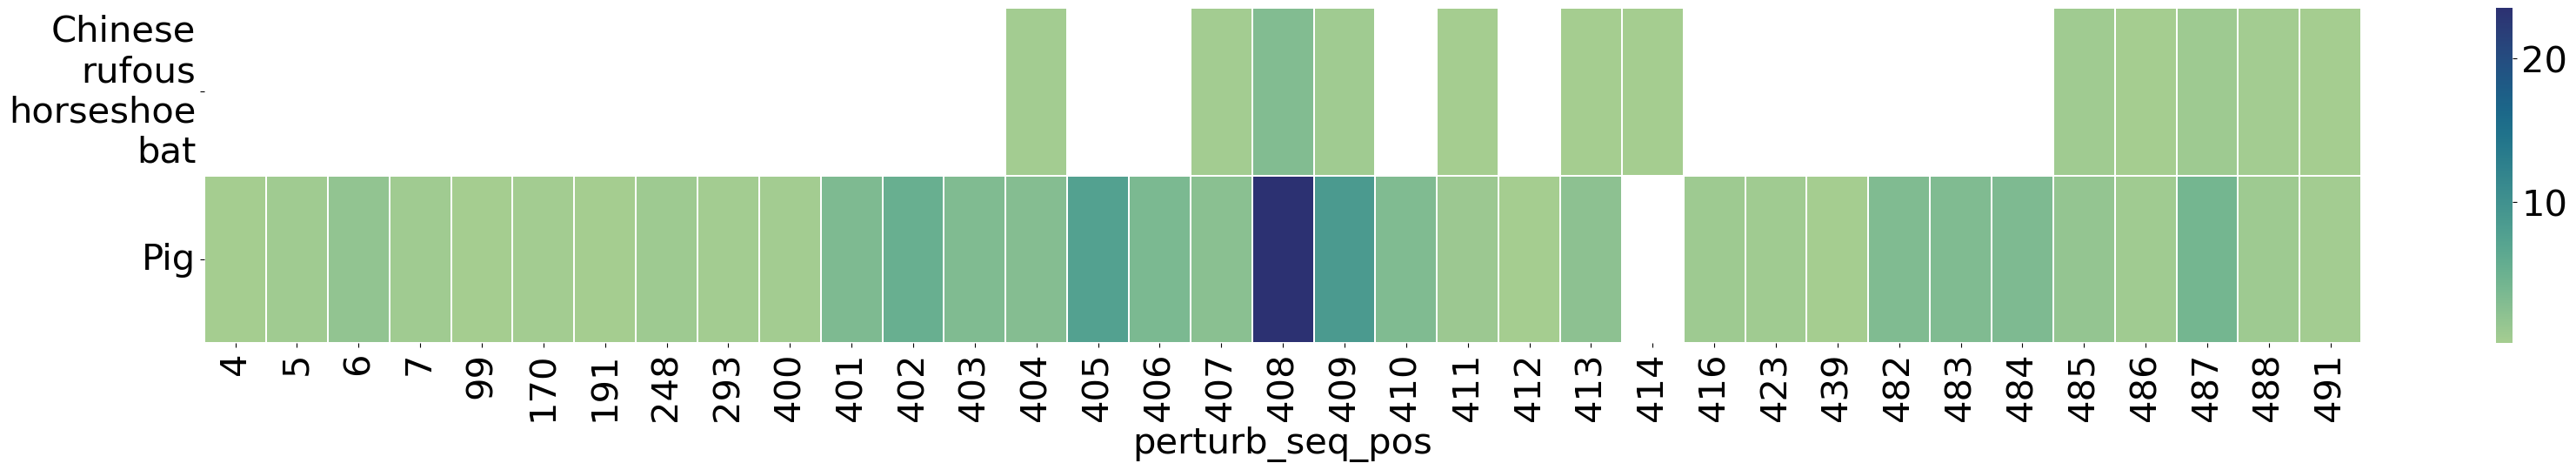

In [25]:
class_change_df = cut_off_df_2[(cut_off_df_2["orig_y_pred"] == "Human") & (cut_off_df_2["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
# df.drop(["new_y_pred"], axis=1, inplace=True)
plt.clf()
plt.figure(figsize=(40, 5))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.heatmap(data=df.T, linewidth=.1, cmap="crest")
wrap_yticklabels(ax, label_width=10, break_long_words=True)
ax.tick_params(axis='x', rotation=90)
plt.show()

## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [26]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

/tmp/ipykernel_28019/3113693862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]


In [27]:
#!pip install textalloc


<Figure size 640x480 with 0 Axes>

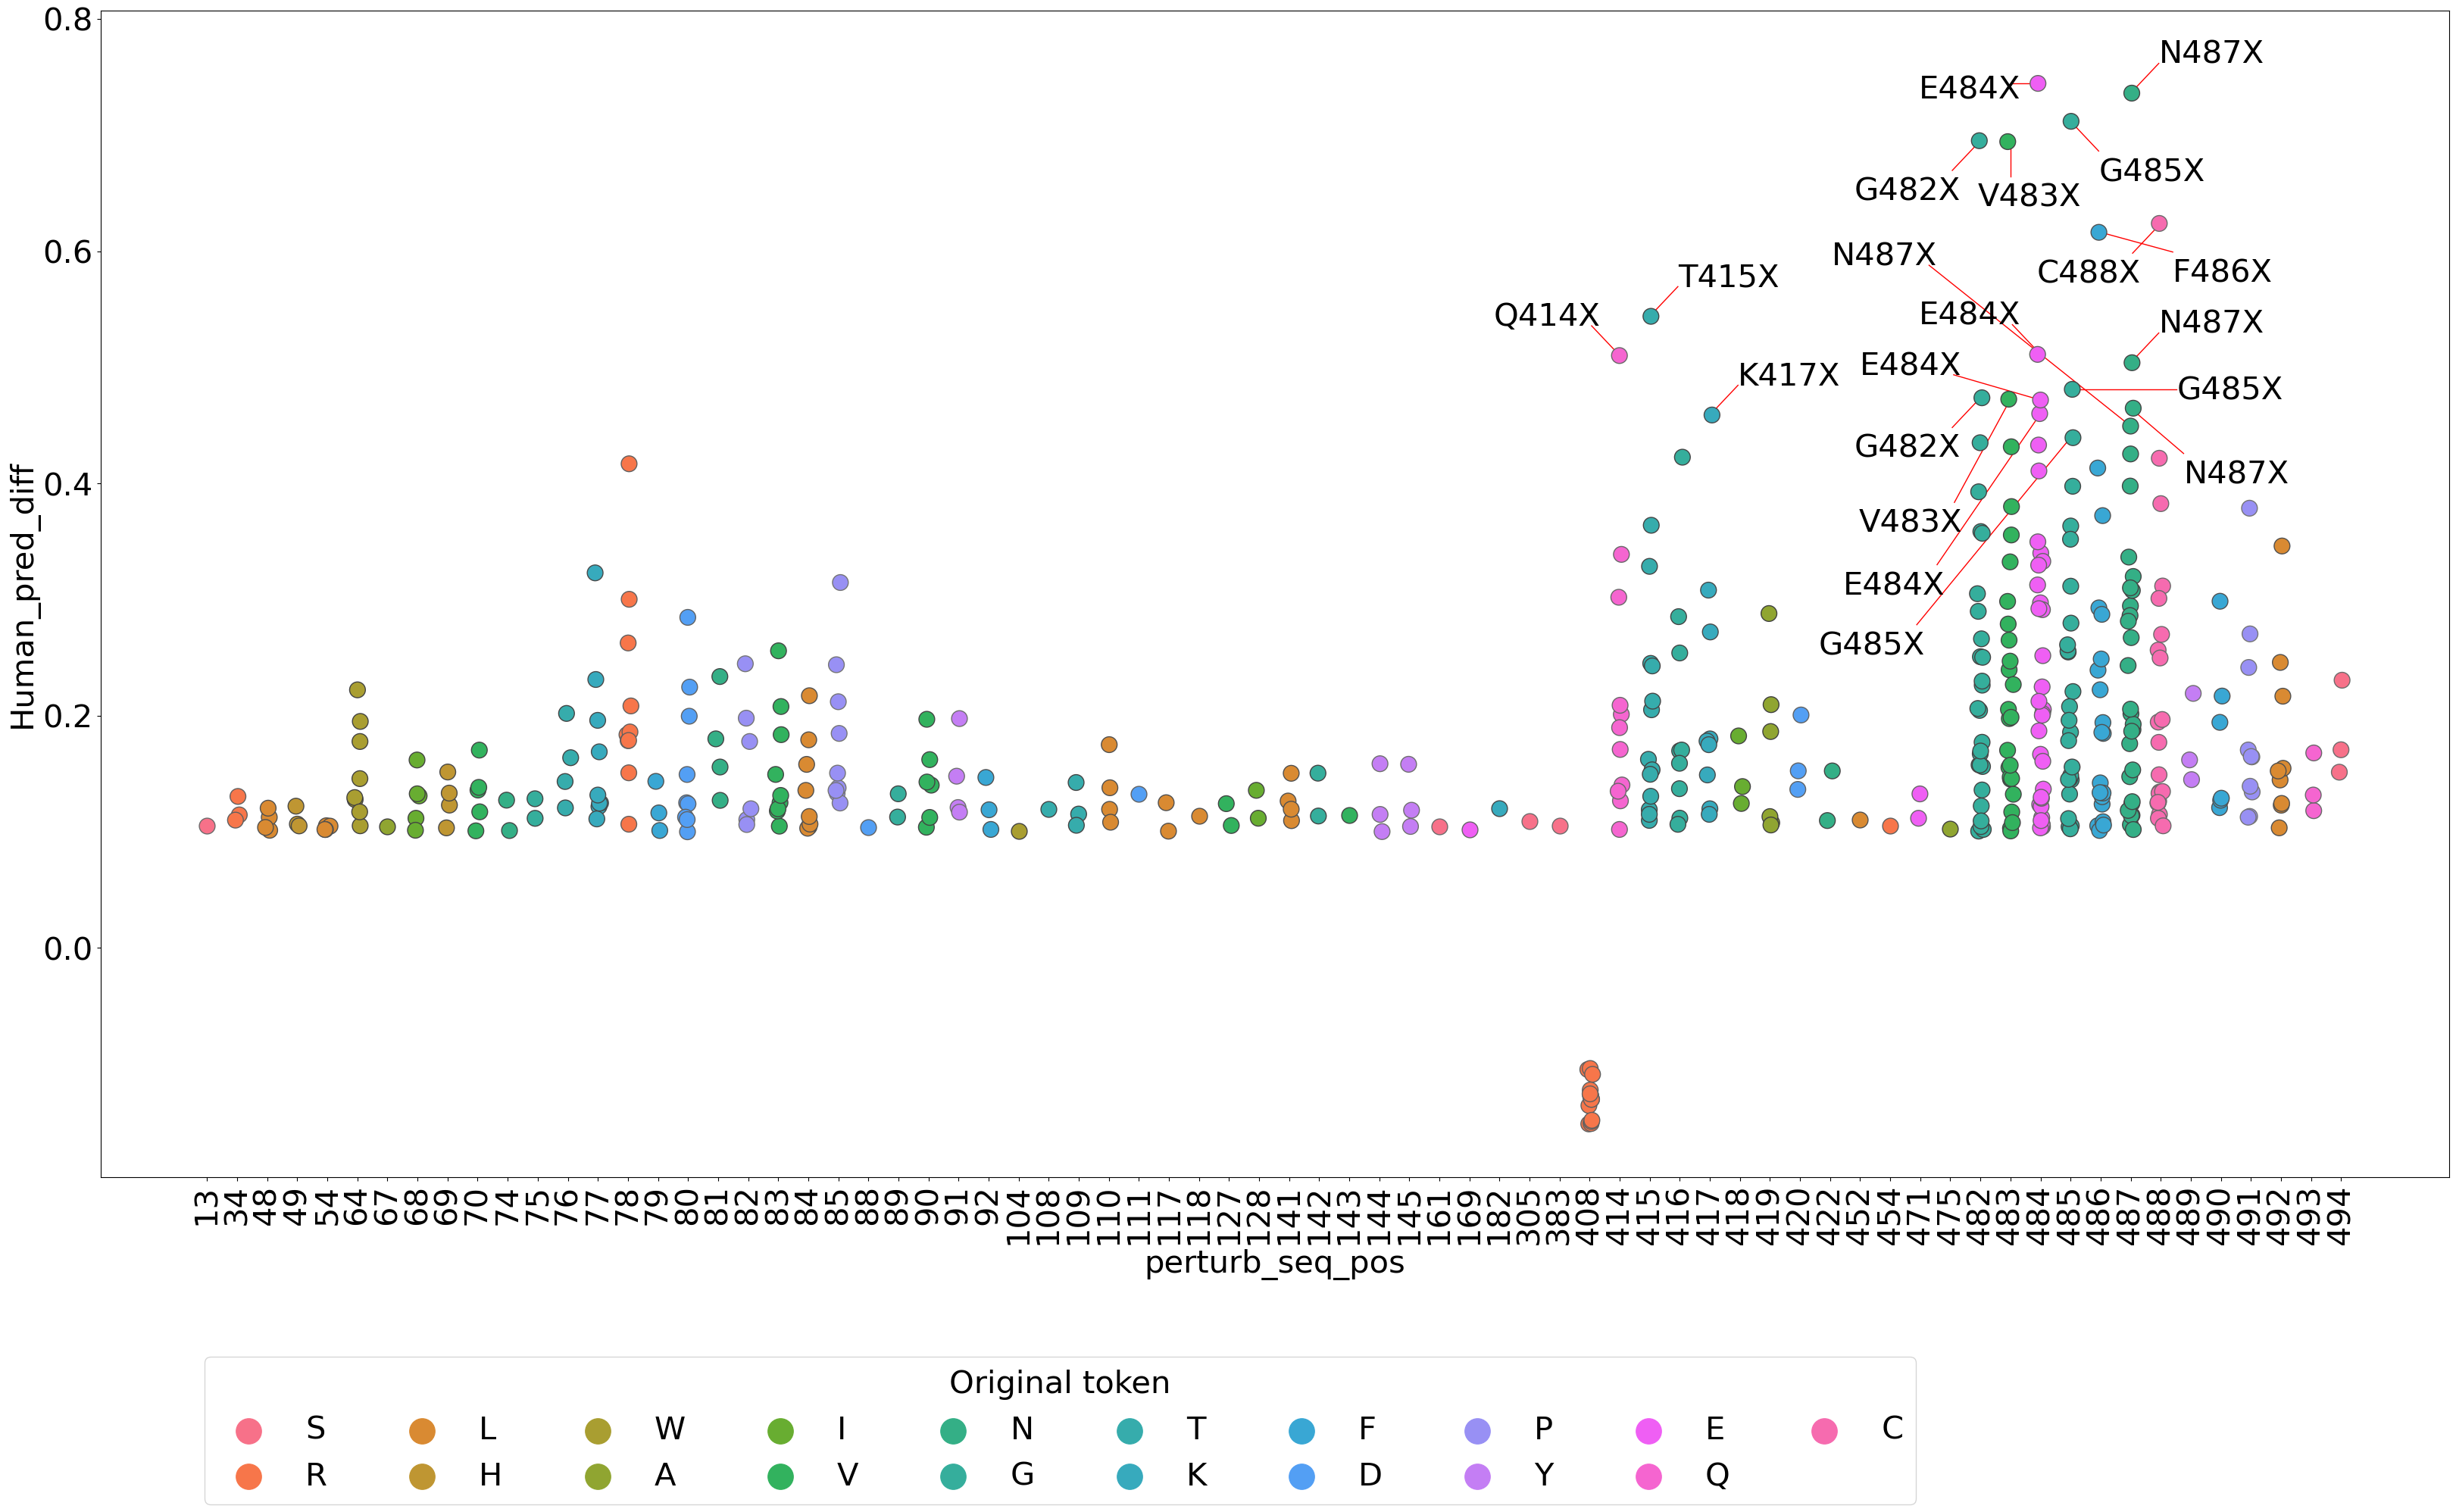

In [28]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [29]:
annotate_df

Cat   Chicken  Chinese rufous horseshoe bat    Ferret  Gray wolf  \
20452  0.000008  0.001149                      0.036094  0.000041   0.000161   
2469   0.000008  0.001267                      0.042944  0.000045   0.000173   
11762  0.000013  0.001175                      0.060889  0.000085   0.000218   
2347   0.000015  0.001009                      0.073336  0.000112   0.000232   
19340  0.000015  0.001094                      0.074143  0.000107   0.000237   
21498  0.000021  0.001011                      0.127156  0.000202   0.000296   
22658  0.000021  0.001076                      0.131763  0.000204   0.000341   
25758  0.000023  0.000847                      0.181454  0.000288   0.000359   
20401  0.000010  0.001309                      0.031493  0.000055   0.000212   
8519   0.000026  0.000867                      0.202863  0.000349   0.000420   
29381  0.000011  0.001402                      0.037469  0.000058   0.000221   
30256  0.000019  0.001331                      0.053234  0.000119   0.000294   
22836  0.000020  0.001188                      0.058421  0.000136   0.000300   
9728   0.000019  0.001267                      0.059484  0.000131   0.000304   
29999  0.000011  0.001192                      0.032611  0.000065   0.000224   
25488  0.000011  0.001270                      0.038585  0.000067   0.000229   
24434  0.000132  0.001322                      0.049218  0.000847   0.000762   
6355   0.000029  0.000901                      0.236950  0.000410   0.000502   
17270  0.000131  0.001406                      0.057214  0.000865   0.000786   
7761   0.000021  0.001212                      0.055330  0.000145   0.000318   

       Horshoe bat     Human       Pig          uniref90_id y_true orig_token  \
20452     0.003146  0.953277  0.006124                WIV04  Human          E   
2469      0.004191  0.944884  0.006487                WIV04  Human          N   
11762     0.005932  0.920613  0.011074                WIV04  Human          G   
2347      0.007247  0.903924  0.014124                WIV04  Human          G   
19340     0.007343  0.903106  0.013955                WIV04  Human          V   
21498     0.013730  0.832663  0.024920                WIV04  Human          C   
22658     0.015658  0.825012  0.025925                WIV04  Human          F   
25758     0.023536  0.752656  0.040837                WIV04  Human          T   
20401     0.002201  0.957600  0.007120  UniRef90_A0A895ZLB7  Human          E   
8519      0.027761  0.718863  0.048851                WIV04  Human          Q   
29381     0.002913  0.950426  0.007500  UniRef90_A0A895ZLB7  Human          N   
30256     0.004164  0.927512  0.013327  UniRef90_A0A895ZLB7  Human          G   
22836     0.004594  0.920235  0.015106  UniRef90_A0A895ZLB7  Human          G   
9728      0.004701  0.919026  0.015069  UniRef90_A0A895ZLB7  Human          V   
29999     0.002171  0.955401  0.008324  UniRef90_A0A8B1JCD7  Human          E   
25488     0.002842  0.948350  0.008646  UniRef90_A0A8B1JCD7  Human          N   
24434     0.003307  0.900092  0.044321  UniRef90_A0A8B6RCH8  Human          E   
6355      0.035260  0.667658  0.058290                WIV04  Human          K   
17270     0.004200  0.889325  0.046072  UniRef90_A0A8B6RCH8  Human          N   
7761      0.004116  0.922956  0.015901  UniRef90_A0A8B1JCD7  Human          G   

       perturb_pos new_token  Human_pred_diff  abs_Human_pred_diff  \
20452         1300         X         0.744596             0.744596   
2469          1303         X         0.736203             0.736203   
11762         1301         X         0.711932             0.711932   
2347          1298         X         0.695243             0.695243   
19340         1299         X         0.694425             0.694425   
21498         1304         X         0.623982             0.623982   
22658         1302         X         0.616331             0.616331   
25758         1101         X         0.543975             0.543975   

### Mutations with new token NOT = X

In [30]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (2681, 19)
Number of unique mutations = 353


<Figure size 640x480 with 0 Axes>

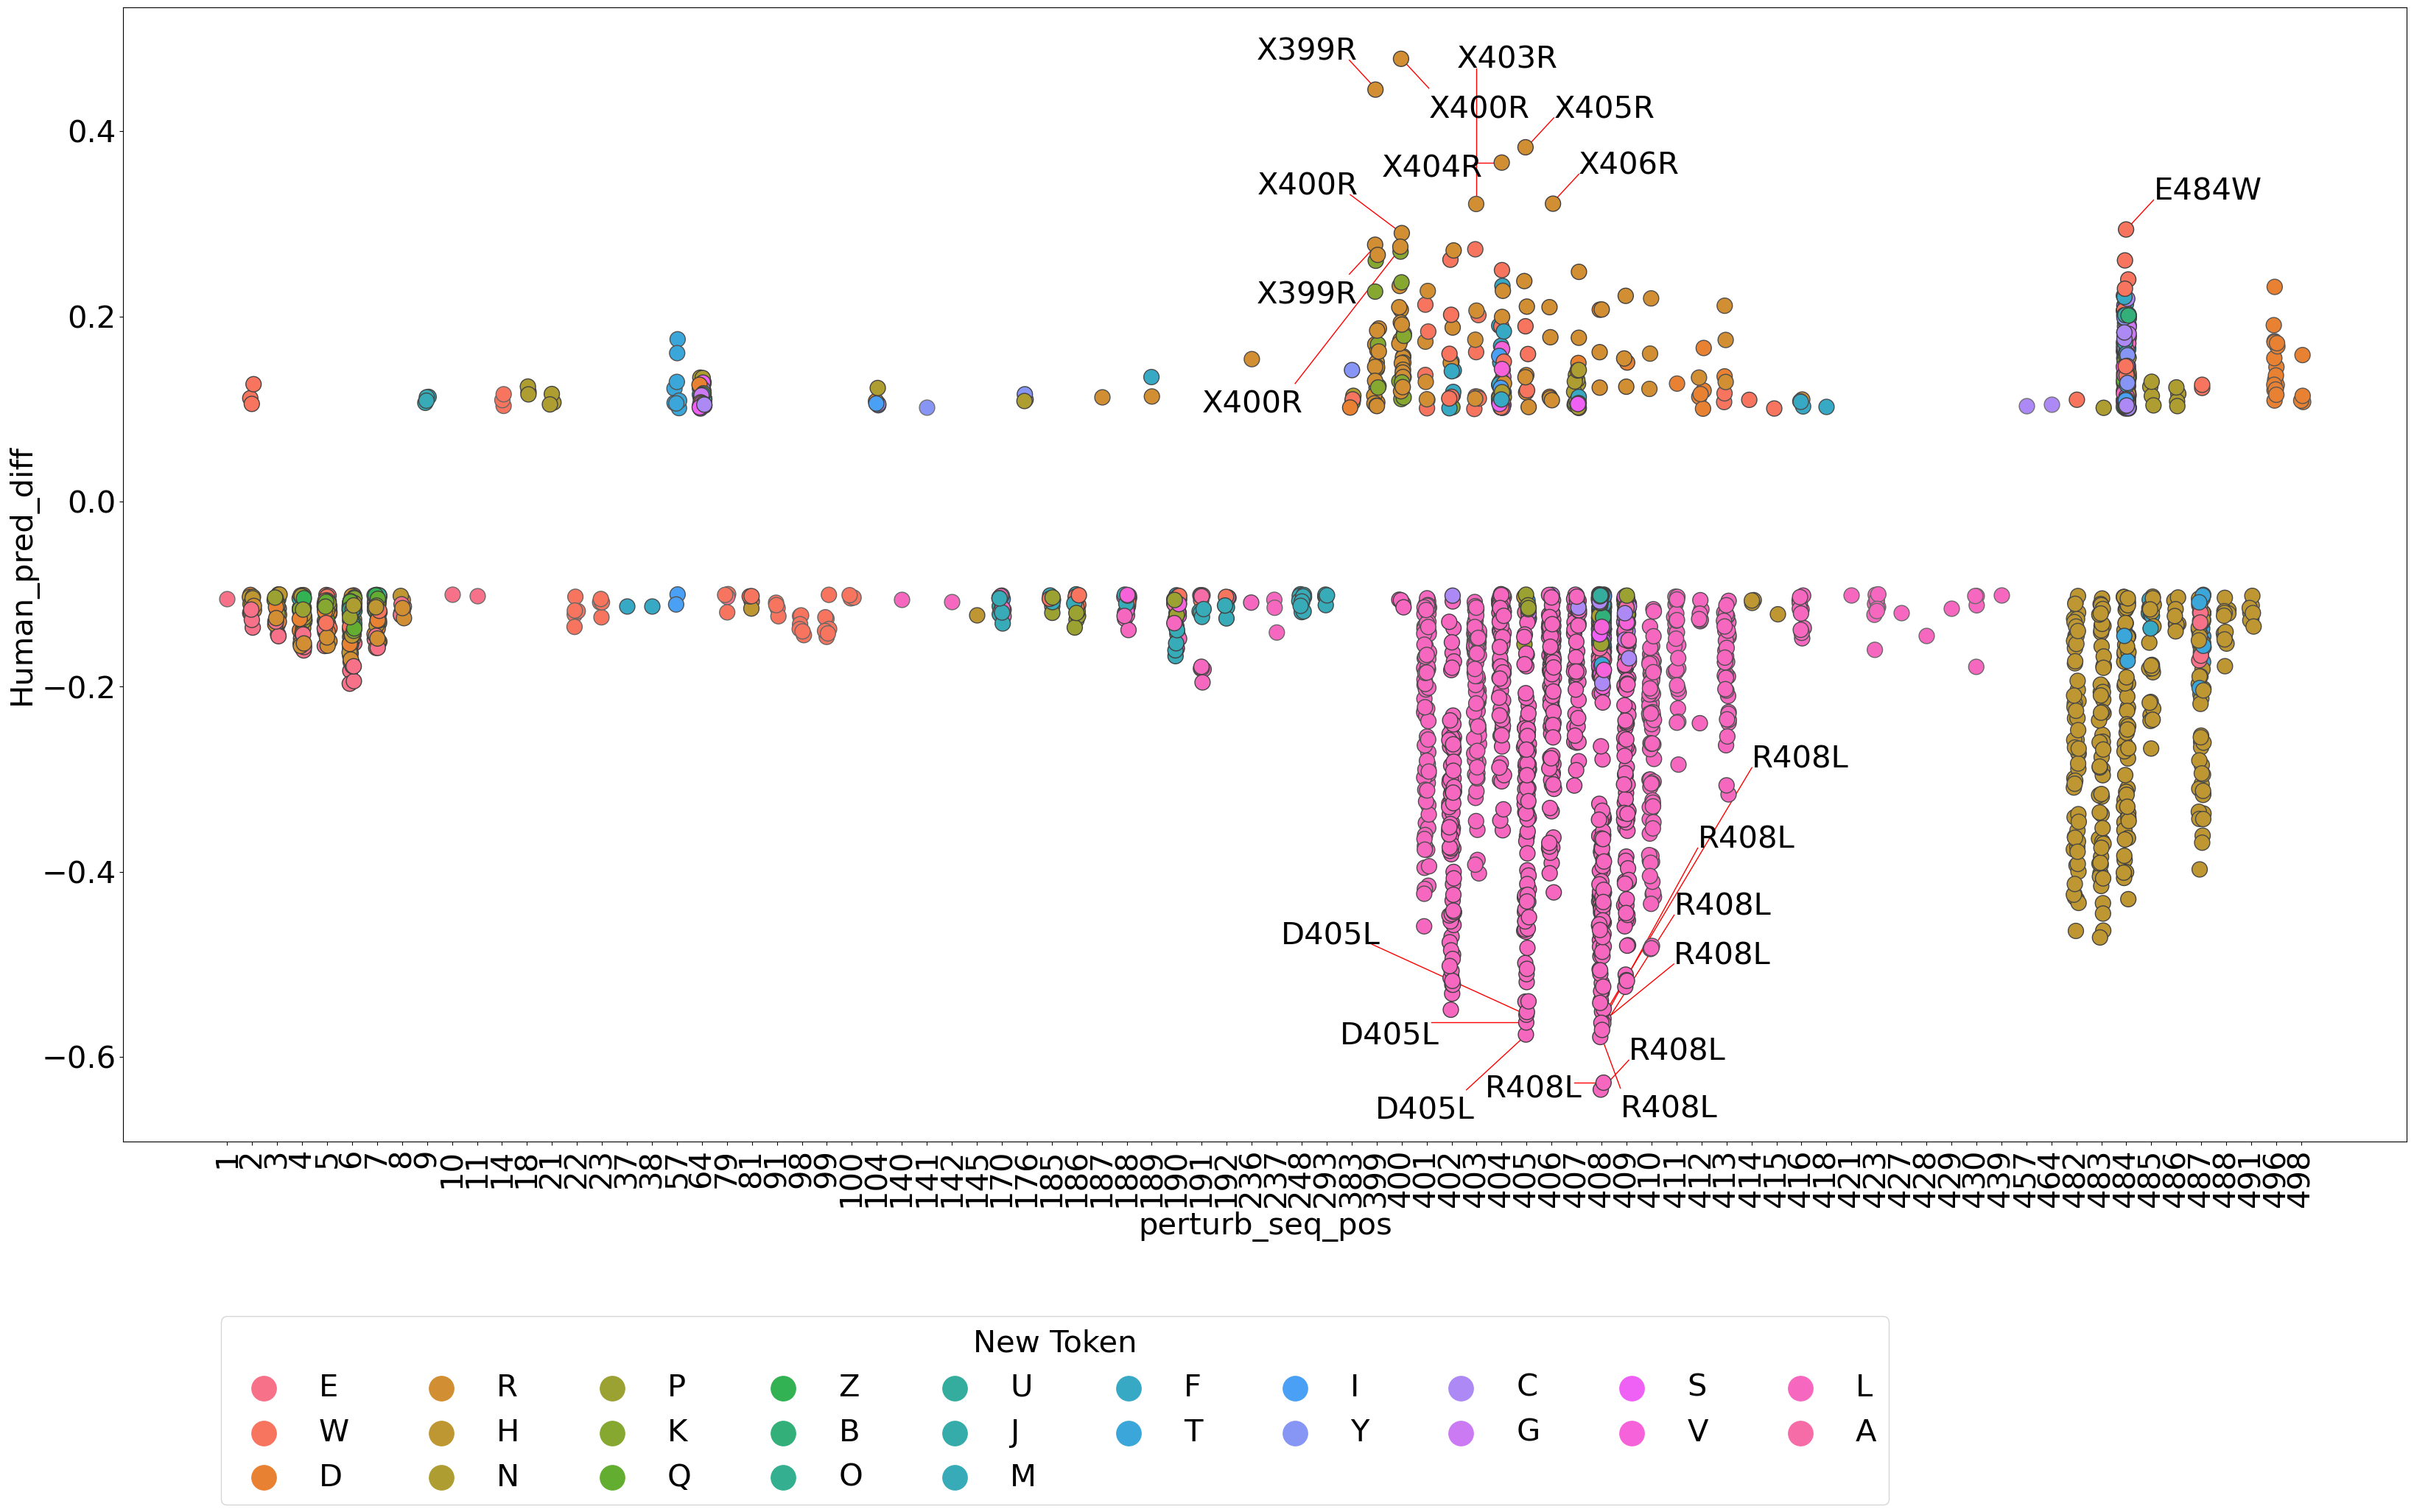

In [31]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [32]:
cut_off_df_2["perturbation_id"].nunique()

425

<Figure size 640x480 with 0 Axes>

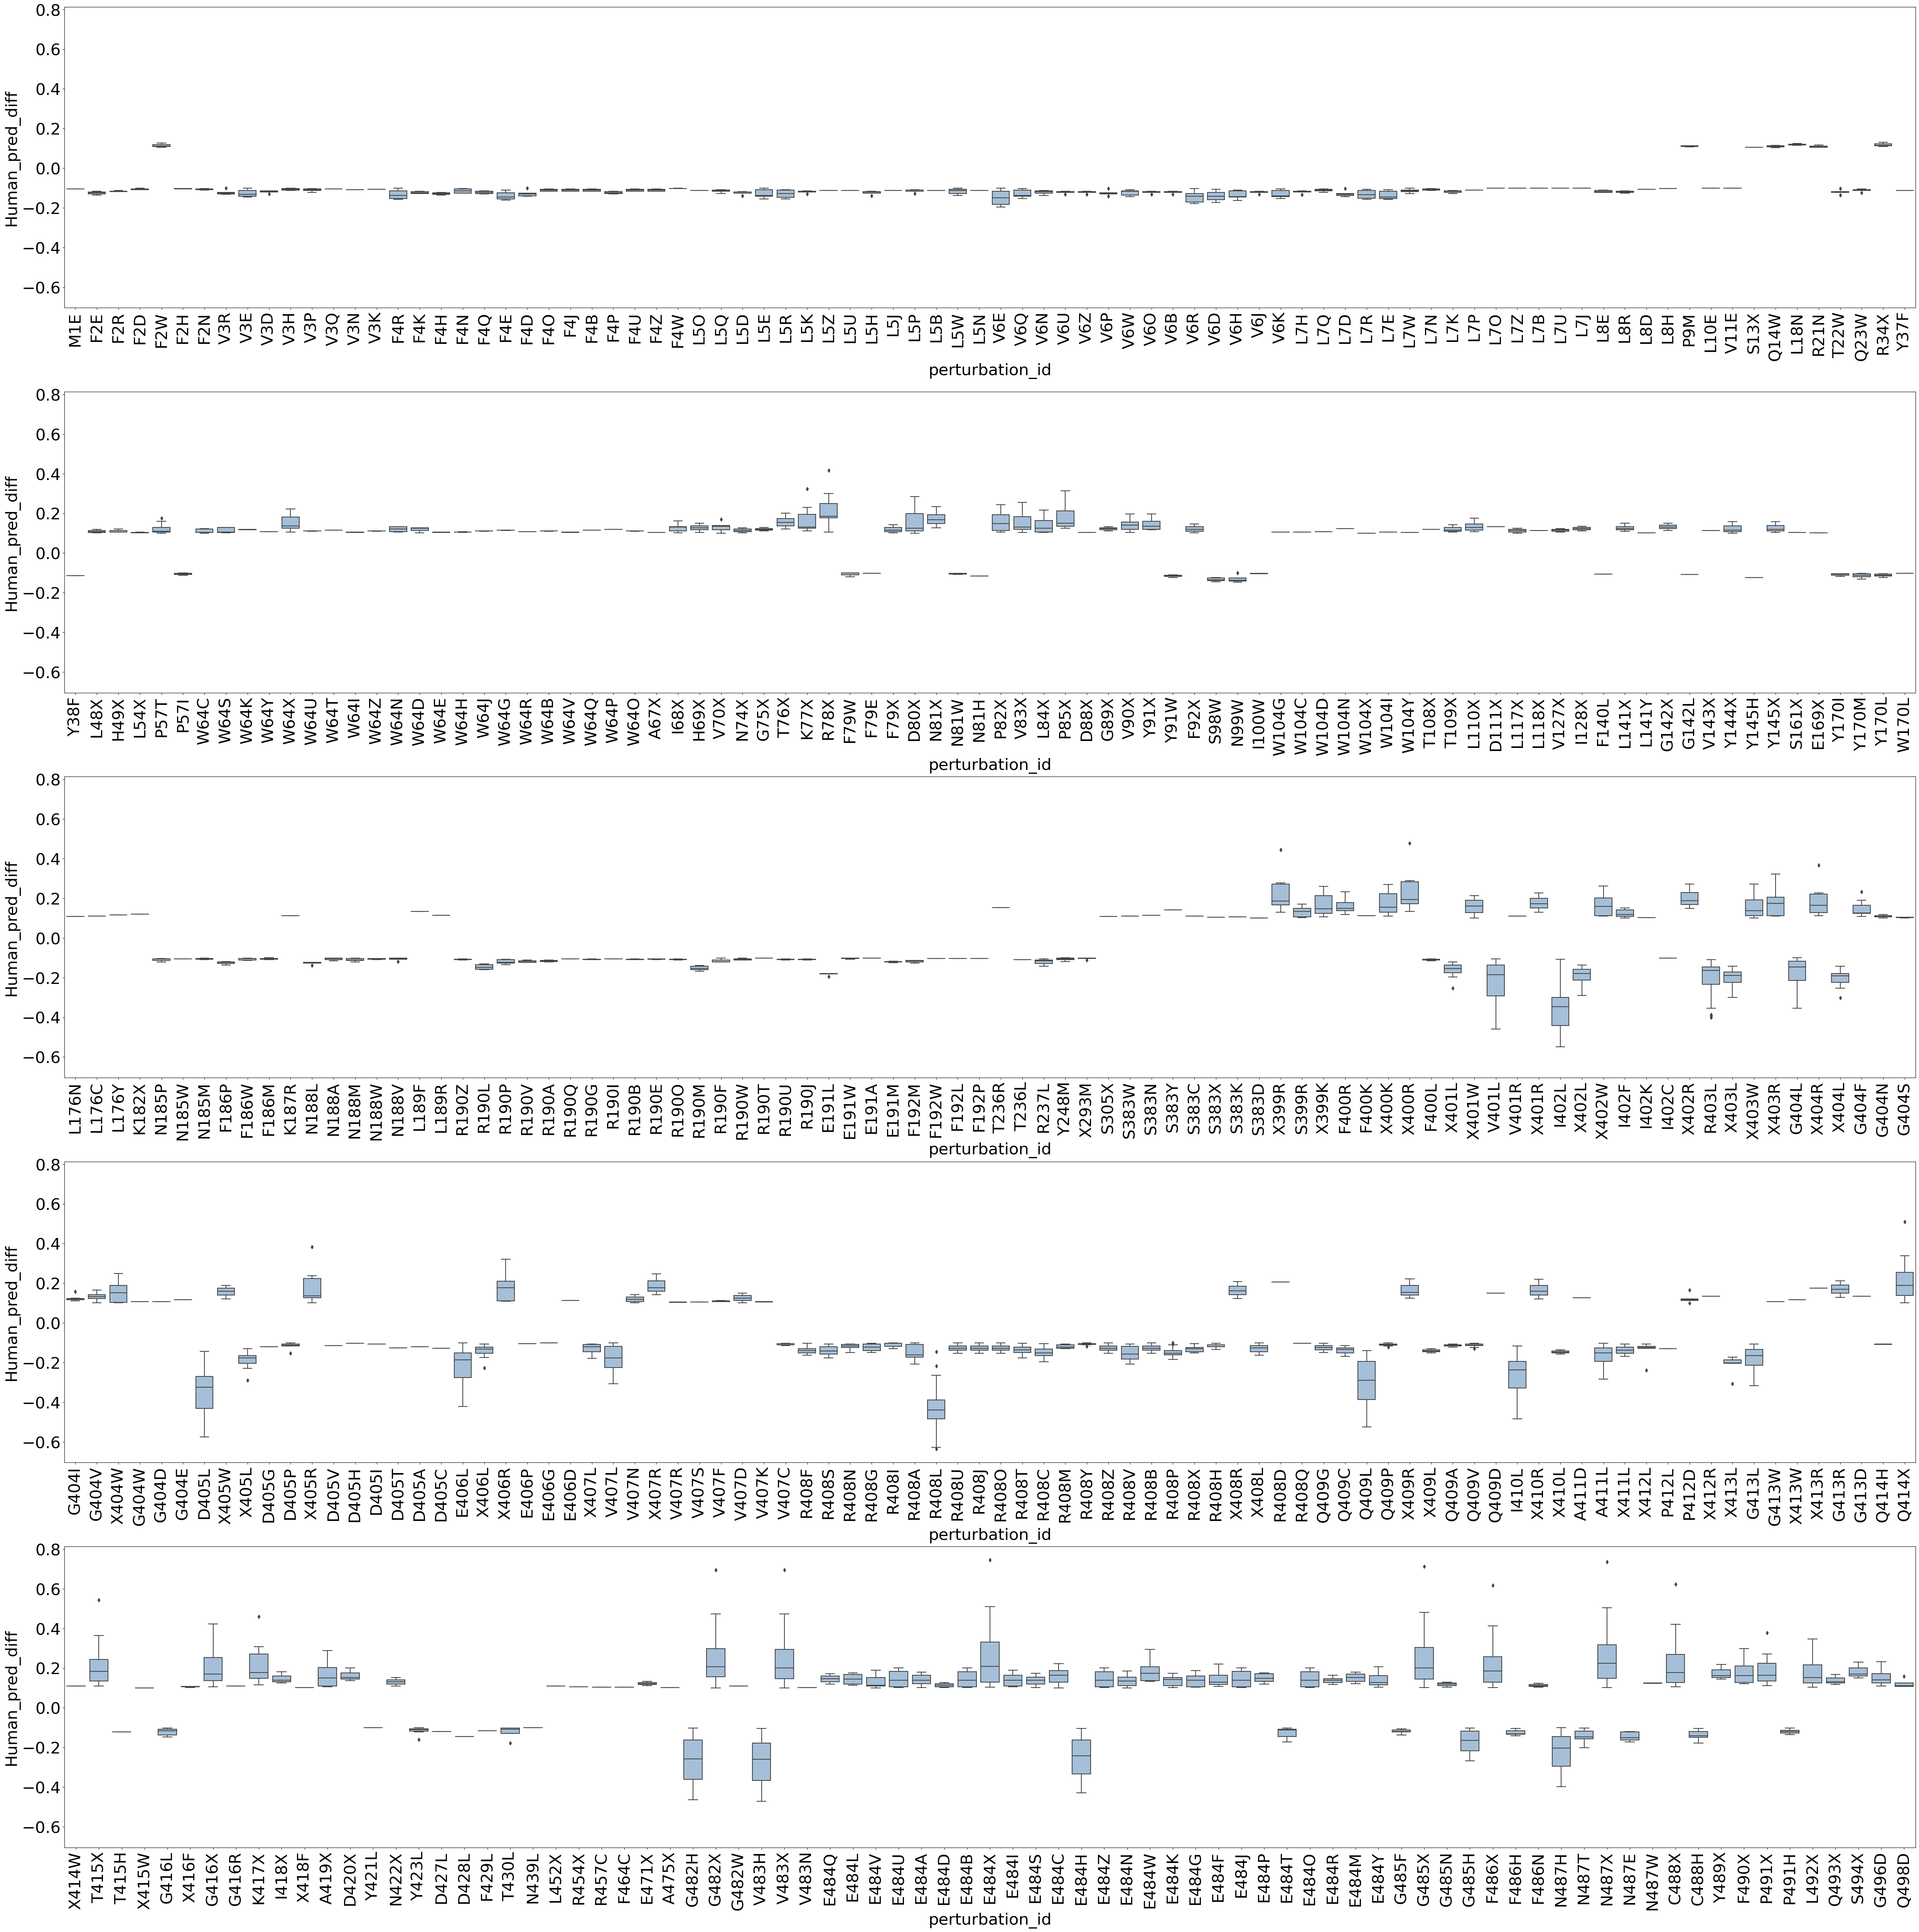

In [33]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(5, 1, figsize=(50, 50), sharex=False, sharey=True)

j = 0
for i in range(0, 426, 86):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(perturbation_ids[i:i+86])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[j], orient="v", order=perturbation_ids[i:i+86],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [34]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

orig_token   pos new_token  Alpha  Delta  XBB perturbation_id
0           T    19         I      0      0    1            T19I
1           T    19         R      0      1    0            T19R
2           L    24         S      0      0    1            L24S
3           A    67         V      0      0    0            A67V
4           V    83         A      0      0    1            V83A
5           T    95         I      0      0    1            T95I
6           G   142         D      0      1    1           G142D
7           H   146         Q      0      0    1           H146Q
8           R   158         G      0      1    0           R158G
9           Q   183         E      0      0    1           Q183E
10          L   212         I      0      0    0           L212I
11          V   213         E      0      0    1           V213E
12          V   213         G      0      0    0           V213G
13          G   339         D      0      0    0           G339D
14          G   339         H      0      0    1           G339H
15          R   346         T      0      0    1           R346T
16          L   368         I      0      0    1           L368I
17          S   371         F      0      0    1           S371F
18          S   371         L      0      0    0           S371L
19          S   373         P      0      0    1           S373P
20          S   375         F      0      0    1           S375F
21          T   376         A      0      0    1           T376A
22          D   405         N      0      0    1           D405N
23          R   408         S      0      0    1           R408S
24          K   417         N      0      0    1           K417N
25          N   440         K      0      0    1           N440K
26          K   444         T      0      0    0           K444T
27          V   445         P      0      0    1           V445P
28          G   446         S      0      0    1           G446S
29          L   452         R      0      1    0           L452R
30          N   460         K      0      0    1           N460K
31          S   477         N      0      0    1           S477N
32          T   478         K      0      1    1           T478K
33          E   484         A      0      0    1           E484A
34          F   486         S      0      0    1           F486S
35          F   486         V      0      0    0           F486V
36          F   490         S      0      0    1           F490S
37          Q   493         R      0      0    0           Q493R
38          G   496         S      0      0    0           G496S
39          Q   498         R      0      0    1           Q498R
40          N   501         Y      1      0    1           N501Y
41          Y   505         H      0      0    1           Y505H
42          T   547         K      0      0    0           T547K
43          A   570         D      1      0    0           A570D
44          D   614         G      1      1    1           D614G
45          H   655         Y      0      0    1           H655Y
46          N   679         K      0      0    1           N679K
47          P   681         H      1      0    1           P681H
48          P   681         R      0      1    0           P681R
49          T   716         I      1      0    0           T716I
50          N   764         K      0      0    1           N764K
51          D   796         Y      0      0    1           D796Y
52          N   856         K      0      0    0           N856K
53          D   950         N      0      1    0           D950N
54          Q   954         H      0      0    1           Q954H
55          N   969         K      0      0    1           N969K
56          L   981         F      0      0    0           L981F
57          S   982         A      1      0    0           S982A
58          D  1118         H      1      0    0          D1118H

In [35]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

/tmp/ipykernel_28019/742767506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)


In [36]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

orig_token   pos new_token  Alpha  Delta  XBB perturbation_id  \
0           T    19         I      0      0    1            T19I   
1           T    19         R      0      1    0            T19R   
2           L    24         S      0      0    1            L24S   
3           A    67         V      0      0    0            A67V   
4           V    83         A      0      0    1            V83A   
5           T    95         I      0      0    1            T95I   
6           G   142         D      0      1    1           G142D   
7           H   146         Q      0      0    1           H146Q   
8           R   158         G      0      1    0           R158G   
9           Q   183         E      0      0    1           Q183E   
10          L   212         I      0      0    0           L212I   
11          V   213         E      0      0    1           V213E   
12          V   213         G      0      0    0           V213G   
13          G   339         D      0      0    0           G339D   
14          G   339         H      0      0    1           G339H   
15          R   346         T      0      0    1           R346T   
16          L   368         I      0      0    1           L368I   
17          S   371         F      0      0    1           S371F   
18          S   371         L      0      0    0           S371L   
19          S   373         P      0      0    1           S373P   
20          S   375         F      0      0    1           S375F   
21          T   376         A      0      0    1           T376A   
22          D   405         N      0      0    1           D405N   
23          R   408         S      0      0    1           R408S   
24          K   417         N      0      0    1           K417N   
25          N   440         K      0      0    1           N440K   
26          K   444         T      0      0    0           K444T   
27          V   445         P      0      0    1           V445P   
28          G   446         S      0      0    1           G446S   
29          L   452         R      0      1    0           L452R   
30          N   460         K      0      0    1           N460K   
31          S   477         N      0      0    1           S477N   
32          T   478         K      0      1    1           T478K   
33          E   484         A      0      0    1           E484A   
34          F   486         S      0      0    1           F486S   
35          F   486         V      0      0    0           F486V   
36          F   490         S      0      0    1           F490S   
37          Q   493         R      0      0    0           Q493R   
38          G   496         S      0      0    0           G496S   
39          Q   498         R      0      0    1           Q498R   
40          N   501         Y      1      0    1           N501Y   
41          Y   505         H      0      0    1           Y505H   
42          T   547         K      0      0    0           T547K   
43          A   570         D      1      0    0           A570D   
44          D   614         G      1      1    1           D614G   
45          H   655         Y      0      0    1           H655Y   
46          N   679         K      0      0    1           N679K   
47          P   681         H      1      0    1           P681H   
48          P   681         R      0      1    0           P681R   
49          T   716         I      1      0    0           T716I   
50          N   764         K      0      0    1           N764K   
51          D   796         Y      0      0    1           D796Y   
52          N   856         K      0      0    0           N856K   
53          D   950         N      0      1    0           D950N   
54          Q   954         H      0      0    1           Q954H   
55          N   969         K      0      0    1           N969K   
56          L   981         F      0      0    0           L981F   
57          S   982         A      1      0    0           

<Figure size 640x480 with 0 Axes>

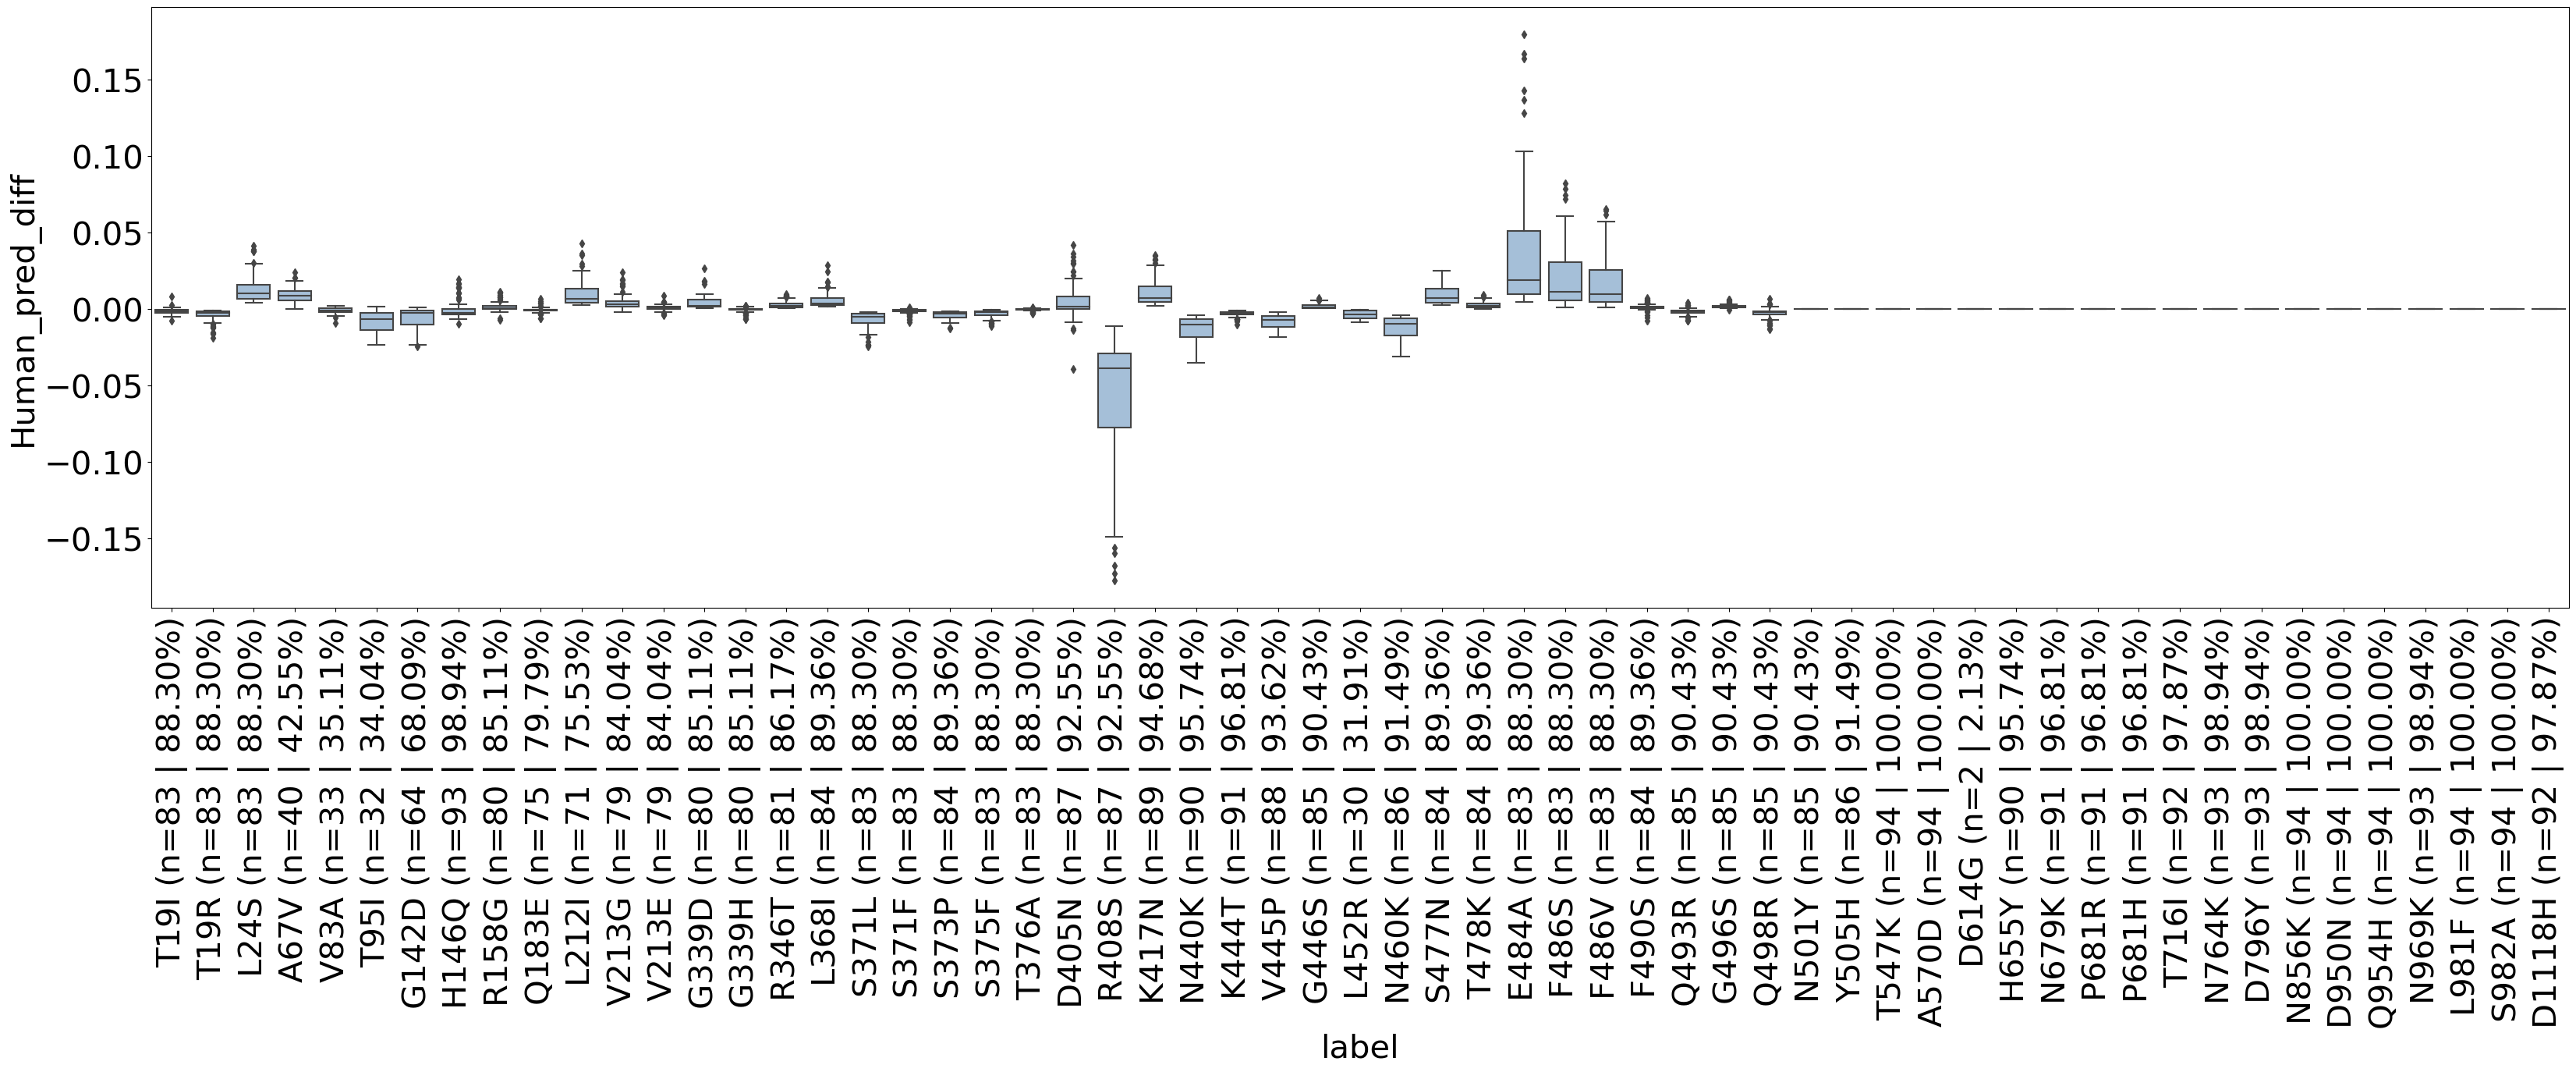

In [37]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="label", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [38]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["perturbation_id"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 425
known_mutations = 59
intersection = {'E484A', 'R408S'}


Perturbation id = E484A
E484X
Perturbation id = R408S
R408X


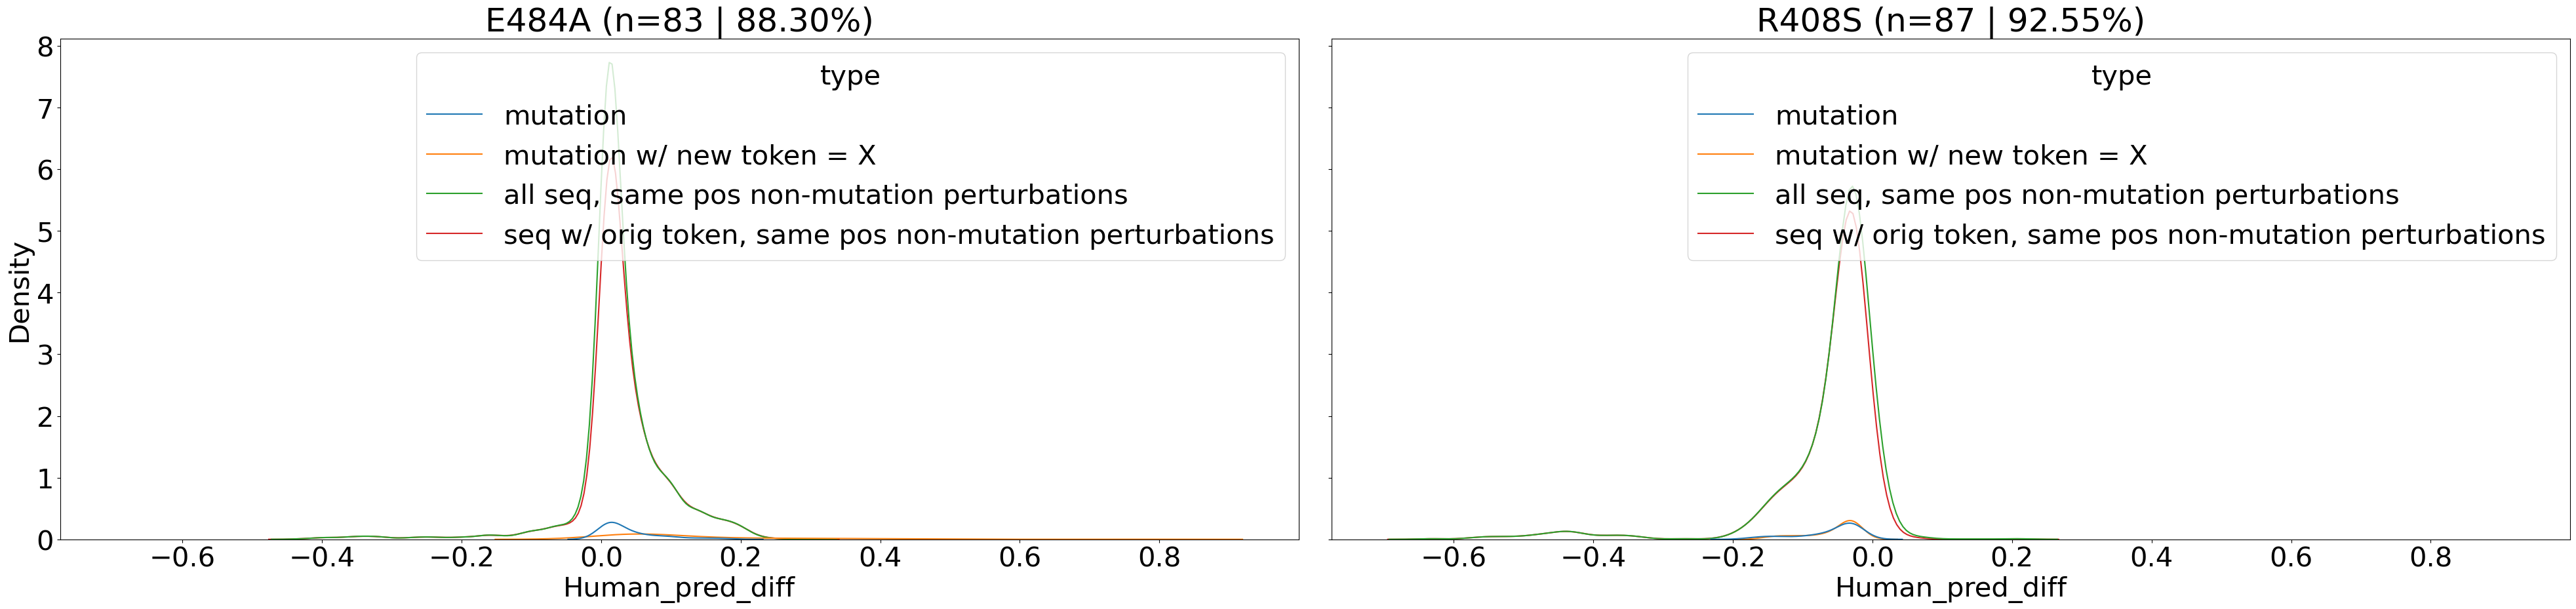

In [54]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

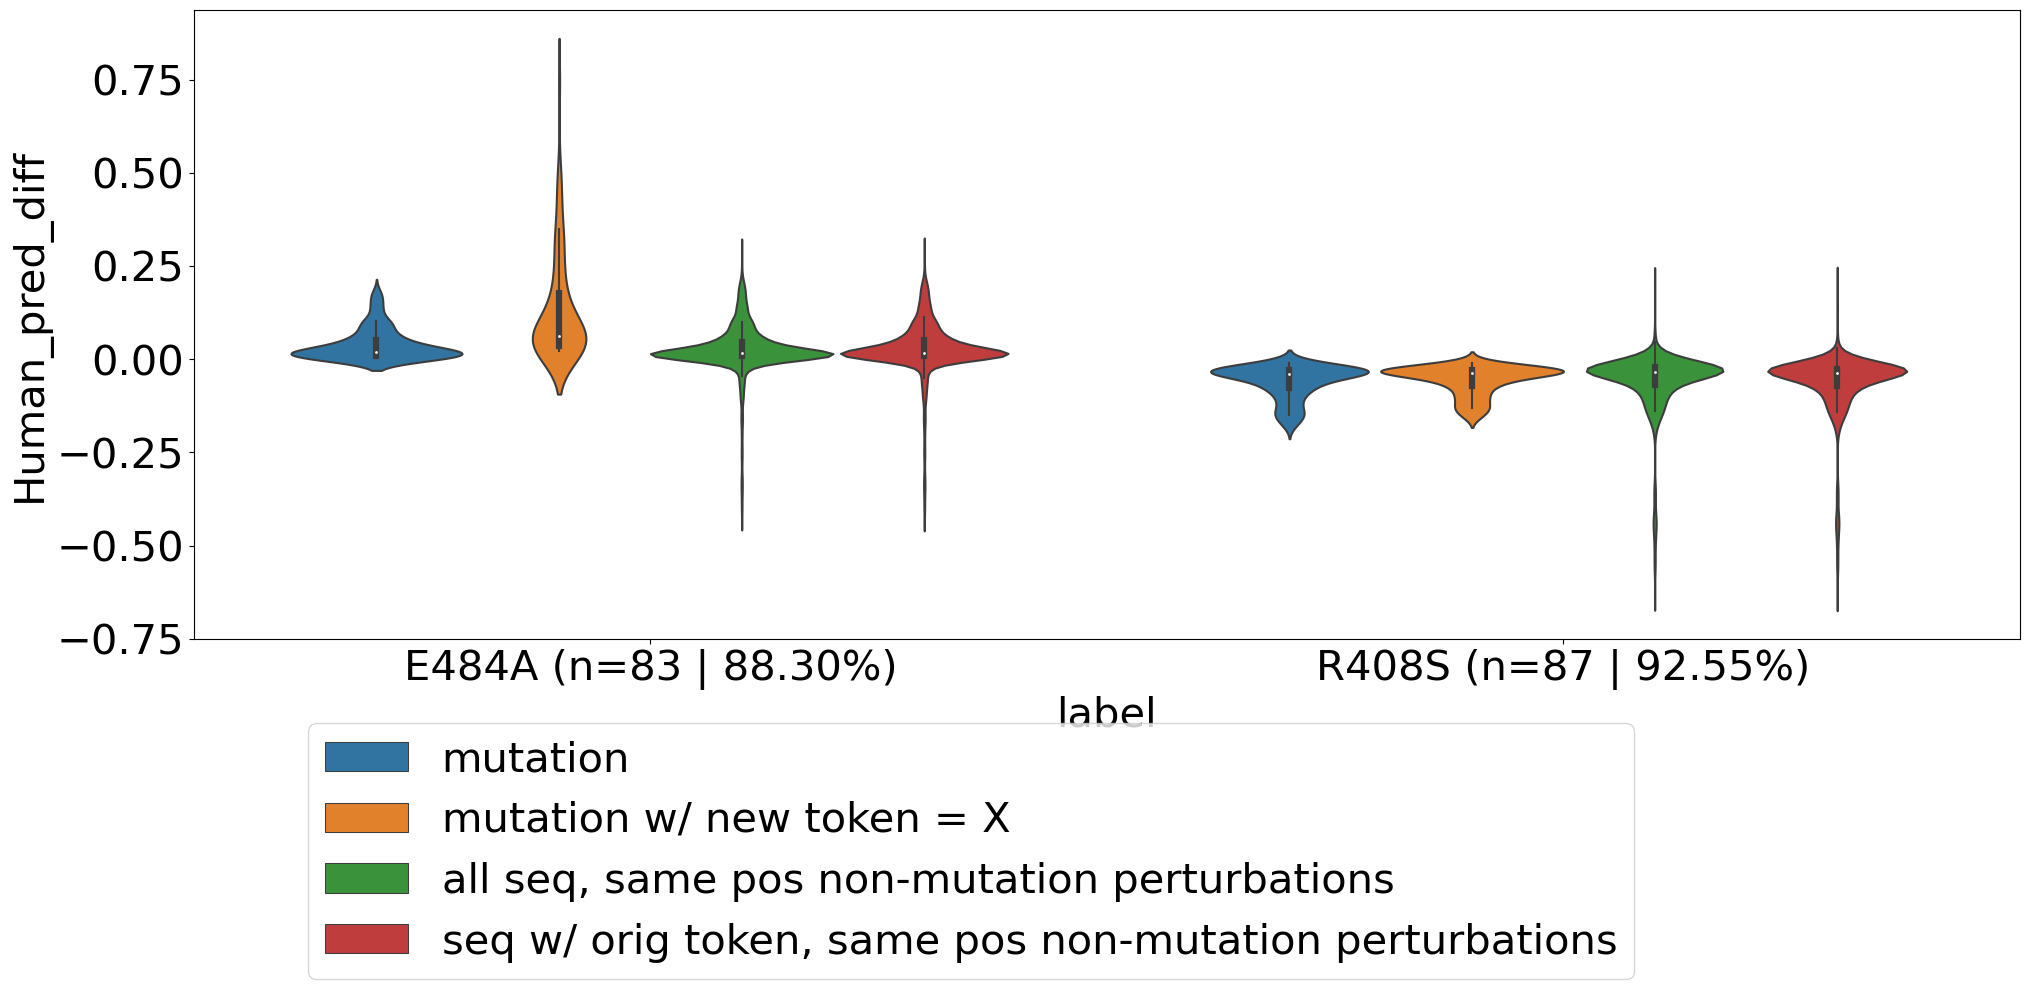

In [55]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

<Figure size 640x480 with 0 Axes>

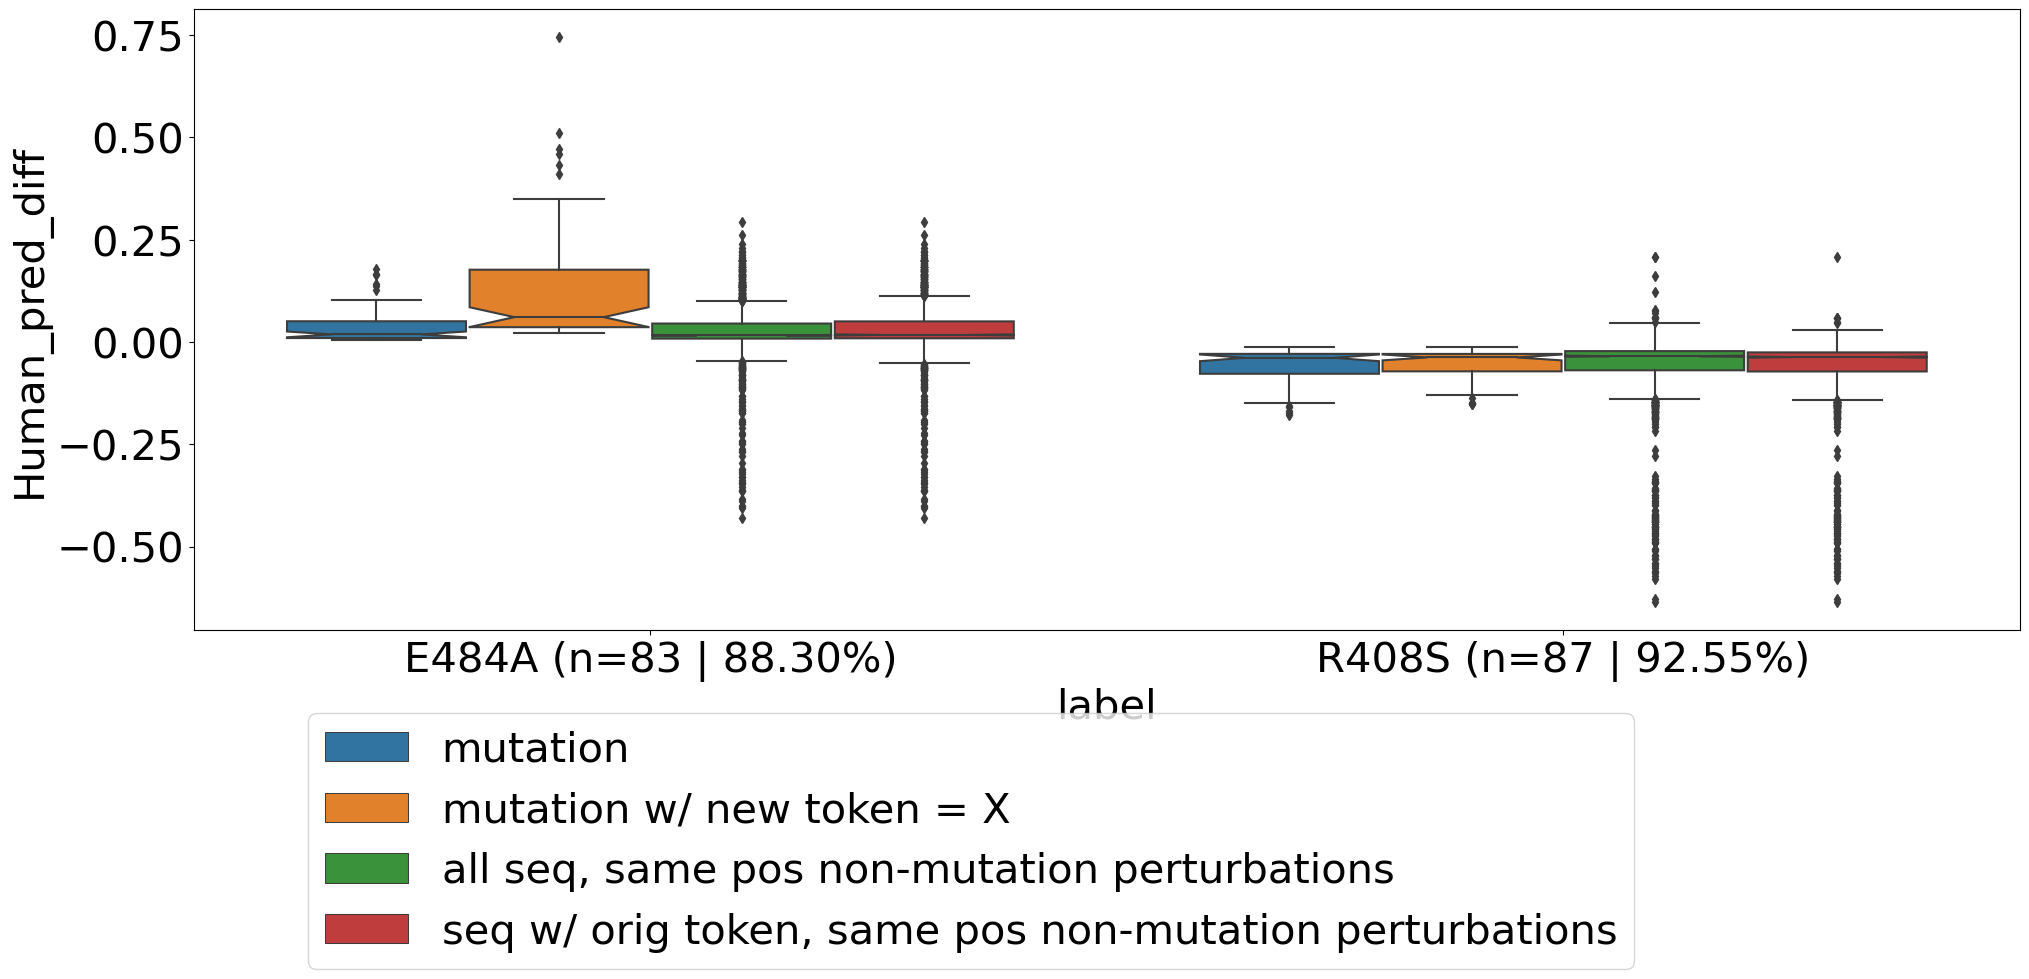

In [56]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

In [42]:
mutation_mean_diff[mutation_mean_diff["mean_Human_pred_diff"] == 0]

NameError: name 'mutation_mean_diff' is not defined

In [ ]:
mutation_mean_diff_selected = mutation_mean_diff[(mutation_mean_diff["mean_Human_pred_diff"] > 0.1) | (mutation_mean_diff["mean_Human_pred_diff"] < -0.1)].sort_values("mean_Human_pred_diff", ascending=True)
mutation_mean_diff_selected

In [ ]:
perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])]

In [ ]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

data = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])][["perturbation_id", "Human_pred_diff"]]
ax = sns.boxplot(data=data, y="Human_pred_diff", x="perturbation_id", order=mutation_mean_diff_selected["perturbation_id"])
plt.xticks(rotation=90)
plt.show()